<a href="https://colab.research.google.com/github/cyndroy/DP_Skin_Cancer_Classification_using_PATE/blob/master/DP_PATE_SkinCancerClassifier_final(50).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install syft

In [2]:
import numpy as np
from PIL import Image
import random
import torch
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
import time, os, random
import tensorflow as tf
import torchvision.models as models
from sklearn.metrics import confusion_matrix


# libary from pysyft needed to perform pate analysis
from syft.frameworks.torch.dp import pate

# we'll train on GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
%cd '/content/drive/My Drive/Colab Notebooks/CancerDataset'

/content/drive/My Drive/Colab Notebooks/CancerDataset


In [4]:
class SkinCancerDataset(Dataset):
    def __init__(self, benign_path, malignant_path, transform=None):

        benign_list = [[os.path.join(benign_path, filename),'0'] for filename in os.listdir(benign_path)] 
        malignant_list = [[os.path.join(malignant_path, filename),'1'] for filename in os.listdir(malignant_path)]
       
        self.img_list = []
        self.img_list = benign_list + malignant_list
        random.shuffle(self.img_list)

        self.transform = transform
      

    def __len__(self):
        return len(self.img_list)   

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = int(self.img_list[idx][1])
        return image, label

In [5]:
data_transforms = transforms.Compose([
    # transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
trainset = SkinCancerDataset(benign_path = './data/train/benign',
                             malignant_path = './data/train/malignant', transform = data_transforms)

testset = SkinCancerDataset(benign_path = './data/test/benign',
                             malignant_path = './data/test/malignant' , transform = data_transforms)

validset = SkinCancerDataset(benign_path = './data/valid/benign',
                             malignant_path = './data/valid/malignant', transform = data_transforms)

len(trainset),len(testset),len(validset)

(2560, 584, 146)

 Image Size torch.Size([16, 3, 224, 224])
 Image Size torch.Size([3, 224, 224])


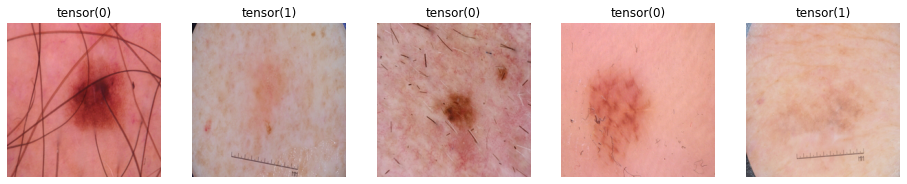

In [6]:
batchsize=16
data_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True)

import matplotlib.pyplot as plt

## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    #print(type(image))
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

# Displaying Images and other info about the train set
ii=0
images, labels = next(iter(data_loader))
print(" Image Size",images.size())
print(" Image Size",images[ii].size())

fig, axes = plt.subplots(figsize=(16,5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    ax.set_title(labels[ii])
    imshow(images[ii], ax=ax, normalize=True)

In [7]:
# TEACHERS
#divide train set among teachers and create dataloaders for valid and trainsets
num_teachers = 5
valid_per = 0.2 #20% for validation
batch_size = 40

def teacher_dataloaders(trainset=trainset, num_teachers=num_teachers, batch_size=batch_size, valid_per = 0.2):
  trainloaders = []
  validloaders = []
  teacher_data_len = len(trainset) // num_teachers

  # create a list of shuffled indices
  my_list = random.sample(range(1,len(trainset)), len(trainset)-1)
  random.shuffle(my_list)

  for i in range(num_teachers):
    # get particular subset of data
    indice = my_list[i*teacher_data_len: (i+1)*teacher_data_len]
    data_subset = Subset(trainset, indice)

    # split into train and validation set
    valid_size = int(len(data_subset) * valid_per)
    train_size = len(data_subset) - valid_size
    train_subset, valid_subset = torch.utils.data.random_split(data_subset, [train_size,valid_size])

    #create data loaders
    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
    validloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

    #add dataloaders to list
    trainloaders.append(trainloader)
    validloaders.append(validloader)

  return trainloaders, validloaders

# creating dataloaders
trainloaders, validloaders = teacher_dataloaders()
len(trainloaders), len(validloaders)

(50, 50)

In [8]:
#  # STUDENT
# split into train and validation set
batch_size = 20
valid_size = int(len(testset) * 0.2)
train_size = len(testset) - valid_size
student_train_subset, student_valid_subset = torch.utils.data.random_split(testset, [train_size,valid_size])

#create data loaders
student_train_loader = DataLoader(student_train_subset, batch_size=batch_size, shuffle=False, num_workers=1)
student_valid_loader = DataLoader(student_valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

len(student_train_loader), len(student_valid_loader)

(24, 6)

In [9]:
#Teacher Model
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__() # b, 3, 32, 32
        layer1 = torch.nn.Sequential()
        layer1.add_module('conv1', torch.nn.Conv2d(3, 32, 3, 1, padding=1))
        layer1.add_module('pool1', torch.nn.MaxPool2d(2, 2))
        layer1.add_module('relu1', torch.nn.ReLU(True))
        layer1.add_module('drop1',torch.nn.Dropout(0.25)) 
        layer1.add_module('conv2', torch.nn.Conv2d(32,64, 3, 1, padding=1))
        layer1.add_module('pool2', torch.nn.MaxPool2d(2, 2)) 
        layer1.add_module('relu2', torch.nn.ReLU(True))
        layer1.add_module('drop2',torch.nn.Dropout(0.25))
        
        self.layer1 = layer1
        layer4 = torch.nn.Sequential()
        layer4.add_module('fc1', torch.nn.Linear(200704, 2))   
           
        self.layer4 = layer4

    def forward(self, x):
        conv1 = self.layer1(x)
        fc_input = conv1.view(conv1.size(0), -1)
        fc_out = self.layer4(fc_input)

        return fc_out

In [10]:
def train(n_epochs, trainloader, validloader, model, optimizer, criterion, use_cuda, save_path= None, is_not_teacher=False):
    """returns trained model"""
    # # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    train_lossL = []
    valid_lossL = []
    train_accL = []
    valid_accL = []

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_correct = 0.0
        train_total = 0.0
        valid_correct =0.0
        valid_total = 0.0
        # train the model #
        model.train()
        for batch_idx, (data, target) in enumerate(trainloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # initialize weights to zero
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()    
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))


            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            train_total += data.size(0)
            train_acc = 100. * train_correct / train_total
        temp_loss = train_loss
        train_lossL.append(temp_loss.cpu().numpy())  
        
        train_accL.append(train_acc)

        # validate the model
        model.eval()
        for batch_idx, (data, target) in enumerate(validloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            valid_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            valid_total += data.size(0)
            valid_acc = 100. * valid_correct / valid_total
        temp_loss = valid_loss
        valid_lossL.append(temp_loss.cpu().numpy())

        valid_accL.append(valid_acc) 

        # print training/validation statistics
        print('Epoch: {} \n\tTrain Loss: {:.6f} \tTrain Acc: {:.6f} \n\tValid Loss: {:.6f} \tValid Acc: {:.6f}'.format(
            epoch,train_loss,train_acc,valid_loss,valid_acc ))

        ## save the student model if validation loss has decreased
        if is_not_teacher:
          if valid_loss < valid_loss_min:
              torch.save(model.state_dict(), save_path)
              print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,
              valid_loss))
              valid_loss_min = valid_loss

    
    epochs = range(1,n_epochs+1)
    plt.plot(epochs, train_lossL, 'g', label='Training loss')
    plt.plot(epochs, valid_lossL, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()  
            
    epochs = range(1,n_epochs+1)
    plt.plot(epochs, train_accL, 'g', label='Training acc')
    plt.plot(epochs, valid_accL, 'b', label='validation acc')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()       

    return model

In [11]:
# instantiate model and move it to GPU if available
model = SimpleCNN()
model.to(device)

#define hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr=0.001)
epochs = 13

 Training Teacher 1
Epoch: 1 
	Train Loss: 0.328392 	Train Acc: 58.536585 
	Valid Loss: 27.298670 	Valid Acc: 50.000000
Epoch: 2 
	Train Loss: 16.752764 	Train Acc: 60.975610 
	Valid Loss: 1.010175 	Valid Acc: 80.000000
Epoch: 3 
	Train Loss: 2.102215 	Train Acc: 73.170732 
	Valid Loss: 1.624492 	Valid Acc: 60.000000
Epoch: 4 
	Train Loss: 0.848352 	Train Acc: 75.609756 
	Valid Loss: 2.564835 	Valid Acc: 60.000000
Epoch: 5 
	Train Loss: 0.849293 	Train Acc: 65.853659 
	Valid Loss: 1.272659 	Valid Acc: 60.000000
Epoch: 6 
	Train Loss: 0.337445 	Train Acc: 82.926829 
	Valid Loss: 0.516971 	Valid Acc: 70.000000
Epoch: 7 
	Train Loss: 1.345351 	Train Acc: 43.902439 
	Valid Loss: 3.056663 	Valid Acc: 50.000000
Epoch: 8 
	Train Loss: 1.679214 	Train Acc: 63.414634 
	Valid Loss: 5.124269 	Valid Acc: 50.000000
Epoch: 9 
	Train Loss: 3.590873 	Train Acc: 60.975610 
	Valid Loss: 4.319230 	Valid Acc: 50.000000
Epoch: 10 
	Train Loss: 3.521074 	Train Acc: 60.975610 
	Valid Loss: 2.337983 	Valid Ac

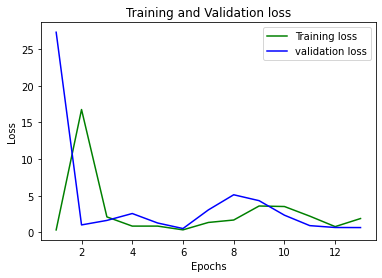

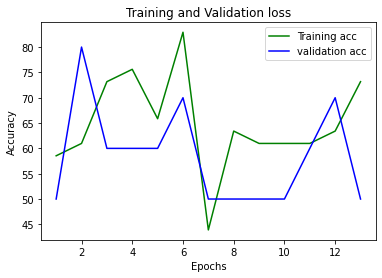

 Training Teacher 2
Epoch: 1 
	Train Loss: 1.142743 	Train Acc: 60.975610 
	Valid Loss: 0.689114 	Valid Acc: 80.000000
Epoch: 2 
	Train Loss: 0.414133 	Train Acc: 75.609756 
	Valid Loss: 0.590347 	Valid Acc: 80.000000
Epoch: 3 
	Train Loss: 0.999752 	Train Acc: 70.731707 
	Valid Loss: 0.560932 	Valid Acc: 80.000000
Epoch: 4 
	Train Loss: 0.305181 	Train Acc: 63.414634 
	Valid Loss: 0.591176 	Valid Acc: 80.000000
Epoch: 5 
	Train Loss: 0.539327 	Train Acc: 68.292683 
	Valid Loss: 0.636430 	Valid Acc: 70.000000
Epoch: 6 
	Train Loss: 0.341464 	Train Acc: 73.170732 
	Valid Loss: 0.654378 	Valid Acc: 70.000000
Epoch: 7 
	Train Loss: 0.338663 	Train Acc: 75.609756 
	Valid Loss: 0.660683 	Valid Acc: 70.000000
Epoch: 8 
	Train Loss: 0.571983 	Train Acc: 80.487805 
	Valid Loss: 0.633980 	Valid Acc: 70.000000
Epoch: 9 
	Train Loss: 0.264625 	Train Acc: 82.926829 
	Valid Loss: 0.609452 	Valid Acc: 70.000000
Epoch: 10 
	Train Loss: 0.229411 	Train Acc: 82.926829 
	Valid Loss: 0.574441 	Valid Acc:

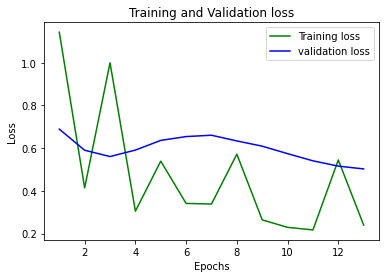

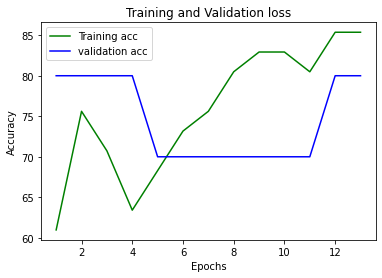

 Training Teacher 3
Epoch: 1 
	Train Loss: 0.700219 	Train Acc: 68.292683 
	Valid Loss: 0.560732 	Valid Acc: 70.000000
Epoch: 2 
	Train Loss: 1.002637 	Train Acc: 70.731707 
	Valid Loss: 0.532304 	Valid Acc: 70.000000
Epoch: 3 
	Train Loss: 0.337081 	Train Acc: 73.170732 
	Valid Loss: 0.529513 	Valid Acc: 70.000000
Epoch: 4 
	Train Loss: 0.597344 	Train Acc: 73.170732 
	Valid Loss: 0.534832 	Valid Acc: 70.000000
Epoch: 5 
	Train Loss: 0.347541 	Train Acc: 75.609756 
	Valid Loss: 0.542520 	Valid Acc: 70.000000
Epoch: 6 
	Train Loss: 0.577479 	Train Acc: 78.048780 
	Valid Loss: 0.530358 	Valid Acc: 80.000000
Epoch: 7 
	Train Loss: 0.534241 	Train Acc: 80.487805 
	Valid Loss: 0.515353 	Valid Acc: 70.000000
Epoch: 8 
	Train Loss: 0.318776 	Train Acc: 75.609756 
	Valid Loss: 0.535063 	Valid Acc: 70.000000
Epoch: 9 
	Train Loss: 1.406570 	Train Acc: 63.414634 
	Valid Loss: 0.496781 	Valid Acc: 70.000000
Epoch: 10 
	Train Loss: 0.368323 	Train Acc: 70.731707 
	Valid Loss: 0.499209 	Valid Acc:

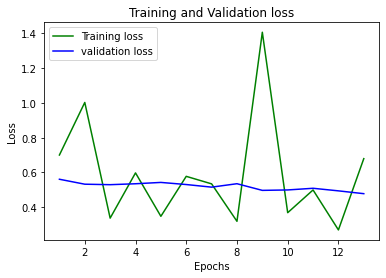

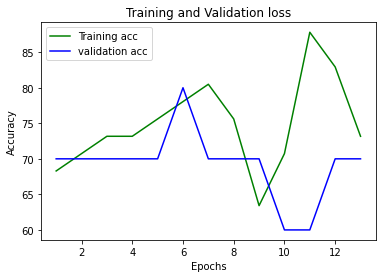

 Training Teacher 4
Epoch: 1 
	Train Loss: 0.310694 	Train Acc: 65.853659 
	Valid Loss: 0.937789 	Valid Acc: 80.000000
Epoch: 2 
	Train Loss: 0.219111 	Train Acc: 85.365854 
	Valid Loss: 0.933628 	Valid Acc: 80.000000
Epoch: 3 
	Train Loss: 0.155033 	Train Acc: 90.243902 
	Valid Loss: 0.933119 	Valid Acc: 80.000000
Epoch: 4 
	Train Loss: 0.123067 	Train Acc: 92.682927 
	Valid Loss: 0.961440 	Valid Acc: 80.000000
Epoch: 5 
	Train Loss: 0.160892 	Train Acc: 92.682927 
	Valid Loss: 0.958097 	Valid Acc: 80.000000
Epoch: 6 
	Train Loss: 0.092383 	Train Acc: 92.682927 
	Valid Loss: 0.923681 	Valid Acc: 70.000000
Epoch: 7 
	Train Loss: 0.083553 	Train Acc: 90.243902 
	Valid Loss: 1.043501 	Valid Acc: 70.000000
Epoch: 8 
	Train Loss: 0.124402 	Train Acc: 90.243902 
	Valid Loss: 0.983188 	Valid Acc: 70.000000
Epoch: 9 
	Train Loss: 0.097253 	Train Acc: 90.243902 
	Valid Loss: 1.030946 	Valid Acc: 70.000000
Epoch: 10 
	Train Loss: 0.084545 	Train Acc: 92.682927 
	Valid Loss: 1.239837 	Valid Acc:

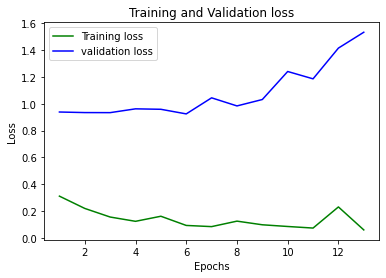

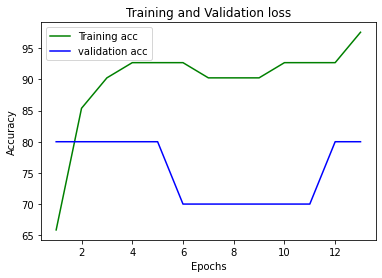

 Training Teacher 5
Epoch: 1 
	Train Loss: 24.006252 	Train Acc: 73.170732 
	Valid Loss: 0.234523 	Valid Acc: 90.000000
Epoch: 2 
	Train Loss: 2.618122 	Train Acc: 78.048780 
	Valid Loss: 0.362512 	Valid Acc: 90.000000
Epoch: 3 
	Train Loss: 4.470178 	Train Acc: 65.853659 
	Valid Loss: 0.561885 	Valid Acc: 70.000000
Epoch: 4 
	Train Loss: 1.255874 	Train Acc: 60.975610 
	Valid Loss: 0.758723 	Valid Acc: 40.000000
Epoch: 5 
	Train Loss: 0.482702 	Train Acc: 65.853659 
	Valid Loss: 0.804085 	Valid Acc: 40.000000
Epoch: 6 
	Train Loss: 0.613206 	Train Acc: 73.170732 
	Valid Loss: 0.832067 	Valid Acc: 50.000000
Epoch: 7 
	Train Loss: 0.724747 	Train Acc: 78.048780 
	Valid Loss: 0.819278 	Valid Acc: 50.000000
Epoch: 8 
	Train Loss: 0.568387 	Train Acc: 75.609756 
	Valid Loss: 0.780809 	Valid Acc: 50.000000
Epoch: 9 
	Train Loss: 0.561212 	Train Acc: 75.609756 
	Valid Loss: 0.753395 	Valid Acc: 50.000000
Epoch: 10 
	Train Loss: 0.555829 	Train Acc: 78.048780 
	Valid Loss: 0.720213 	Valid Acc

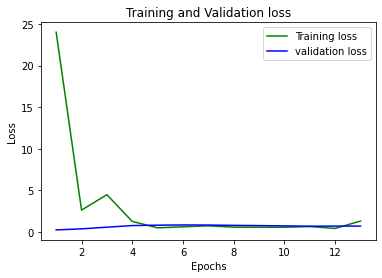

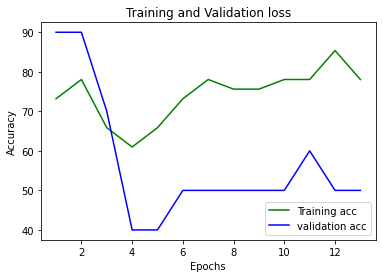

 Training Teacher 6
Epoch: 1 
	Train Loss: 1.114559 	Train Acc: 70.731707 
	Valid Loss: 0.780750 	Valid Acc: 50.000000
Epoch: 2 
	Train Loss: 0.306770 	Train Acc: 75.609756 
	Valid Loss: 0.652031 	Valid Acc: 80.000000
Epoch: 3 
	Train Loss: 0.369178 	Train Acc: 78.048780 
	Valid Loss: 0.613094 	Valid Acc: 90.000000
Epoch: 4 
	Train Loss: 0.614862 	Train Acc: 78.048780 
	Valid Loss: 0.596997 	Valid Acc: 80.000000
Epoch: 5 
	Train Loss: 0.461652 	Train Acc: 78.048780 
	Valid Loss: 0.561285 	Valid Acc: 70.000000
Epoch: 6 
	Train Loss: 0.797632 	Train Acc: 68.292683 
	Valid Loss: 0.504828 	Valid Acc: 70.000000
Epoch: 7 
	Train Loss: 0.537535 	Train Acc: 60.975610 
	Valid Loss: 0.485809 	Valid Acc: 70.000000
Epoch: 8 
	Train Loss: 1.847451 	Train Acc: 58.536585 
	Valid Loss: 0.539999 	Valid Acc: 70.000000
Epoch: 9 
	Train Loss: 0.374815 	Train Acc: 73.170732 
	Valid Loss: 0.574384 	Valid Acc: 90.000000
Epoch: 10 
	Train Loss: 0.279105 	Train Acc: 63.414634 
	Valid Loss: 0.614403 	Valid Acc:

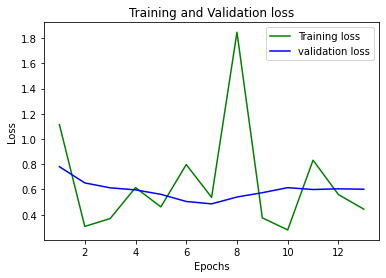

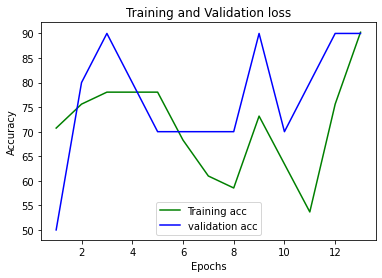

 Training Teacher 7
Epoch: 1 
	Train Loss: 0.492558 	Train Acc: 80.487805 
	Valid Loss: 0.665405 	Valid Acc: 70.000000
Epoch: 2 
	Train Loss: 0.660680 	Train Acc: 78.048780 
	Valid Loss: 0.656840 	Valid Acc: 70.000000
Epoch: 3 
	Train Loss: 0.424226 	Train Acc: 80.487805 
	Valid Loss: 0.652545 	Valid Acc: 70.000000
Epoch: 4 
	Train Loss: 0.513525 	Train Acc: 75.609756 
	Valid Loss: 0.645666 	Valid Acc: 70.000000
Epoch: 5 
	Train Loss: 0.568887 	Train Acc: 78.048780 
	Valid Loss: 0.634535 	Valid Acc: 70.000000
Epoch: 6 
	Train Loss: 0.684787 	Train Acc: 78.048780 
	Valid Loss: 0.607306 	Valid Acc: 70.000000
Epoch: 7 
	Train Loss: 0.913672 	Train Acc: 80.487805 
	Valid Loss: 0.578412 	Valid Acc: 70.000000
Epoch: 8 
	Train Loss: 0.318038 	Train Acc: 75.609756 
	Valid Loss: 0.621880 	Valid Acc: 60.000000
Epoch: 9 
	Train Loss: 0.390413 	Train Acc: 68.292683 
	Valid Loss: 0.536214 	Valid Acc: 60.000000
Epoch: 10 
	Train Loss: 2.551658 	Train Acc: 68.292683 
	Valid Loss: 0.502459 	Valid Acc:

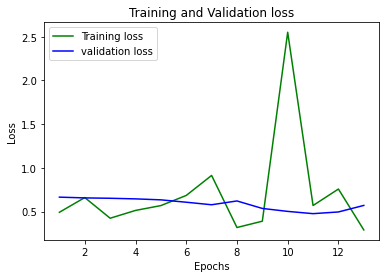

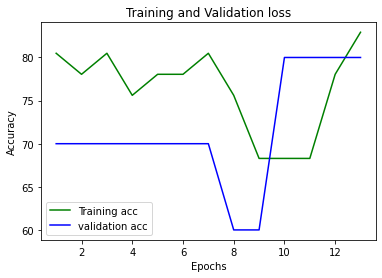

 Training Teacher 8
Epoch: 1 
	Train Loss: 0.256093 	Train Acc: 85.365854 
	Valid Loss: 0.600294 	Valid Acc: 60.000000
Epoch: 2 
	Train Loss: 1.517687 	Train Acc: 85.365854 
	Valid Loss: 0.641683 	Valid Acc: 60.000000
Epoch: 3 
	Train Loss: 0.345267 	Train Acc: 78.048780 
	Valid Loss: 0.843742 	Valid Acc: 40.000000
Epoch: 4 
	Train Loss: 0.440186 	Train Acc: 73.170732 
	Valid Loss: 0.780015 	Valid Acc: 40.000000
Epoch: 5 
	Train Loss: 0.918030 	Train Acc: 82.926829 
	Valid Loss: 0.630831 	Valid Acc: 60.000000
Epoch: 6 
	Train Loss: 0.311186 	Train Acc: 75.609756 
	Valid Loss: 0.645091 	Valid Acc: 50.000000
Epoch: 7 
	Train Loss: 0.524924 	Train Acc: 56.097561 
	Valid Loss: 0.631380 	Valid Acc: 60.000000
Epoch: 8 
	Train Loss: 0.316649 	Train Acc: 82.926829 
	Valid Loss: 0.688253 	Valid Acc: 60.000000
Epoch: 9 
	Train Loss: 0.273213 	Train Acc: 82.926829 
	Valid Loss: 0.929483 	Valid Acc: 70.000000
Epoch: 10 
	Train Loss: 0.331821 	Train Acc: 80.487805 
	Valid Loss: 1.111186 	Valid Acc:

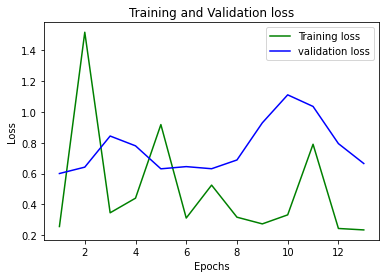

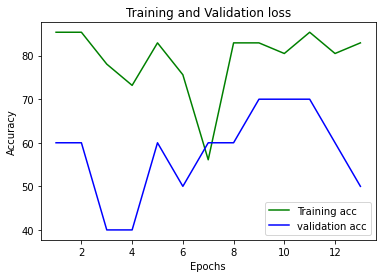

 Training Teacher 9
Epoch: 1 
	Train Loss: 0.589150 	Train Acc: 82.926829 
	Valid Loss: 0.456765 	Valid Acc: 80.000000
Epoch: 2 
	Train Loss: 0.180152 	Train Acc: 87.804878 
	Valid Loss: 0.473226 	Valid Acc: 80.000000
Epoch: 3 
	Train Loss: 0.166107 	Train Acc: 87.804878 
	Valid Loss: 0.527820 	Valid Acc: 80.000000
Epoch: 4 
	Train Loss: 0.210537 	Train Acc: 87.804878 
	Valid Loss: 0.537125 	Valid Acc: 80.000000
Epoch: 5 
	Train Loss: 0.310690 	Train Acc: 87.804878 
	Valid Loss: 0.537574 	Valid Acc: 80.000000
Epoch: 6 
	Train Loss: 0.872449 	Train Acc: 87.804878 
	Valid Loss: 0.499086 	Valid Acc: 80.000000
Epoch: 7 
	Train Loss: 0.204405 	Train Acc: 90.243902 
	Valid Loss: 0.432705 	Valid Acc: 80.000000
Epoch: 8 
	Train Loss: 0.230429 	Train Acc: 90.243902 
	Valid Loss: 0.385669 	Valid Acc: 80.000000
Epoch: 9 
	Train Loss: 0.148148 	Train Acc: 87.804878 
	Valid Loss: 0.366591 	Valid Acc: 80.000000
Epoch: 10 
	Train Loss: 0.607590 	Train Acc: 87.804878 
	Valid Loss: 0.389327 	Valid Acc:

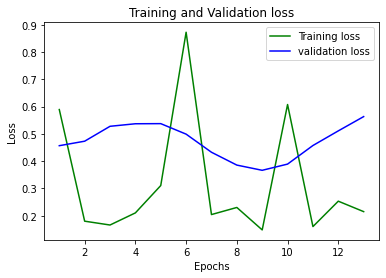

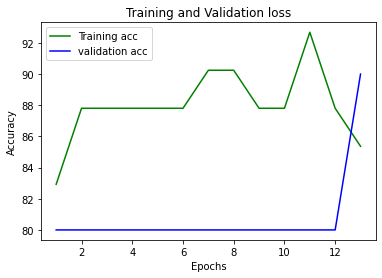

 Training Teacher 10
Epoch: 1 
	Train Loss: 0.626136 	Train Acc: 65.853659 
	Valid Loss: 0.313242 	Valid Acc: 90.000000
Epoch: 2 
	Train Loss: 0.953874 	Train Acc: 63.414634 
	Valid Loss: 0.275989 	Valid Acc: 90.000000
Epoch: 3 
	Train Loss: 0.401890 	Train Acc: 70.731707 
	Valid Loss: 0.263870 	Valid Acc: 90.000000
Epoch: 4 
	Train Loss: 1.814281 	Train Acc: 70.731707 
	Valid Loss: 0.331877 	Valid Acc: 90.000000
Epoch: 5 
	Train Loss: 0.389837 	Train Acc: 70.731707 
	Valid Loss: 0.391043 	Valid Acc: 100.000000
Epoch: 6 
	Train Loss: 1.006633 	Train Acc: 68.292683 
	Valid Loss: 0.436648 	Valid Acc: 100.000000
Epoch: 7 
	Train Loss: 1.084182 	Train Acc: 68.292683 
	Valid Loss: 0.494568 	Valid Acc: 90.000000
Epoch: 8 
	Train Loss: 0.341478 	Train Acc: 78.048780 
	Valid Loss: 0.509829 	Valid Acc: 90.000000
Epoch: 9 
	Train Loss: 0.458166 	Train Acc: 82.926829 
	Valid Loss: 0.532187 	Valid Acc: 70.000000
Epoch: 10 
	Train Loss: 0.678992 	Train Acc: 75.609756 
	Valid Loss: 0.551386 	Valid A

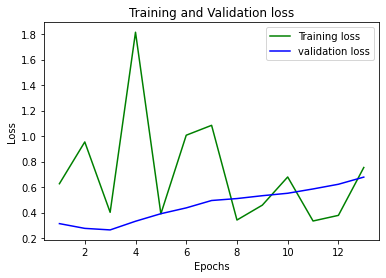

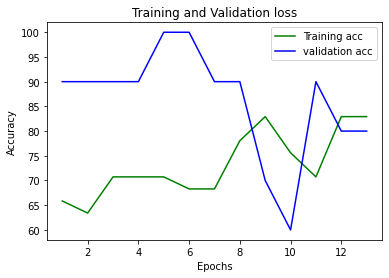

 Training Teacher 11
Epoch: 1 
	Train Loss: 0.403187 	Train Acc: 75.609756 
	Valid Loss: 0.656870 	Valid Acc: 70.000000
Epoch: 2 
	Train Loss: 0.373317 	Train Acc: 73.170732 
	Valid Loss: 0.742899 	Valid Acc: 40.000000
Epoch: 3 
	Train Loss: 0.577684 	Train Acc: 68.292683 
	Valid Loss: 0.719167 	Valid Acc: 50.000000
Epoch: 4 
	Train Loss: 0.397711 	Train Acc: 70.731707 
	Valid Loss: 0.661411 	Valid Acc: 50.000000
Epoch: 5 
	Train Loss: 0.340866 	Train Acc: 73.170732 
	Valid Loss: 0.587508 	Valid Acc: 70.000000
Epoch: 6 
	Train Loss: 0.460170 	Train Acc: 68.292683 
	Valid Loss: 0.557889 	Valid Acc: 70.000000
Epoch: 7 
	Train Loss: 0.468584 	Train Acc: 73.170732 
	Valid Loss: 0.677522 	Valid Acc: 70.000000
Epoch: 8 
	Train Loss: 0.943313 	Train Acc: 78.048780 
	Valid Loss: 0.567890 	Valid Acc: 80.000000
Epoch: 9 
	Train Loss: 0.441889 	Train Acc: 78.048780 
	Valid Loss: 0.487423 	Valid Acc: 90.000000
Epoch: 10 
	Train Loss: 0.477438 	Train Acc: 82.926829 
	Valid Loss: 0.516961 	Valid Acc

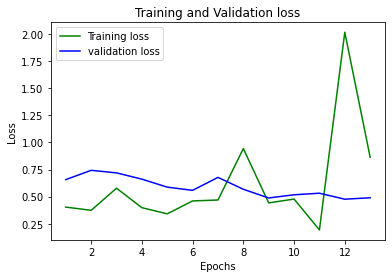

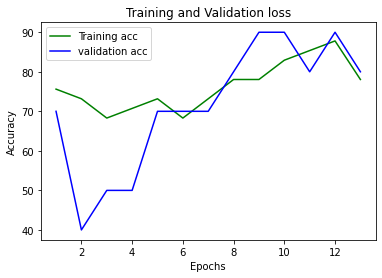

 Training Teacher 12
Epoch: 1 
	Train Loss: 0.461520 	Train Acc: 63.414634 
	Valid Loss: 0.758144 	Valid Acc: 80.000000
Epoch: 2 
	Train Loss: 0.397876 	Train Acc: 60.975610 
	Valid Loss: 0.680562 	Valid Acc: 80.000000
Epoch: 3 
	Train Loss: 0.743898 	Train Acc: 58.536585 
	Valid Loss: 0.665561 	Valid Acc: 80.000000
Epoch: 4 
	Train Loss: 1.384719 	Train Acc: 58.536585 
	Valid Loss: 0.660288 	Valid Acc: 70.000000
Epoch: 5 
	Train Loss: 0.627189 	Train Acc: 65.853659 
	Valid Loss: 0.664393 	Valid Acc: 70.000000
Epoch: 6 
	Train Loss: 0.356678 	Train Acc: 82.926829 
	Valid Loss: 0.843325 	Valid Acc: 40.000000
Epoch: 7 
	Train Loss: 0.833130 	Train Acc: 51.219512 
	Valid Loss: 0.705440 	Valid Acc: 60.000000
Epoch: 8 
	Train Loss: 0.477143 	Train Acc: 70.731707 
	Valid Loss: 0.690811 	Valid Acc: 70.000000
Epoch: 9 
	Train Loss: 0.941094 	Train Acc: 80.487805 
	Valid Loss: 0.683401 	Valid Acc: 50.000000
Epoch: 10 
	Train Loss: 0.334946 	Train Acc: 78.048780 
	Valid Loss: 0.670226 	Valid Acc

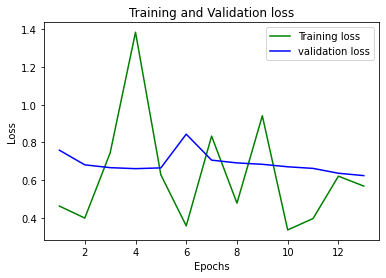

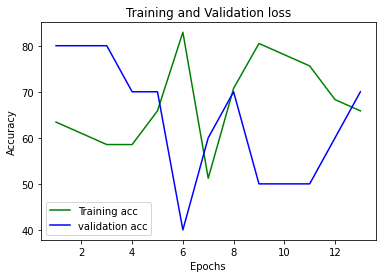

 Training Teacher 13
Epoch: 1 
	Train Loss: 0.586022 	Train Acc: 68.292683 
	Valid Loss: 0.545122 	Valid Acc: 80.000000
Epoch: 2 
	Train Loss: 0.258919 	Train Acc: 68.292683 
	Valid Loss: 0.546392 	Valid Acc: 80.000000
Epoch: 3 
	Train Loss: 0.265003 	Train Acc: 68.292683 
	Valid Loss: 0.524204 	Valid Acc: 70.000000
Epoch: 4 
	Train Loss: 0.277914 	Train Acc: 60.975610 
	Valid Loss: 0.527772 	Valid Acc: 80.000000
Epoch: 5 
	Train Loss: 0.662299 	Train Acc: 65.853659 
	Valid Loss: 0.507114 	Valid Acc: 70.000000
Epoch: 6 
	Train Loss: 0.250752 	Train Acc: 63.414634 
	Valid Loss: 0.520718 	Valid Acc: 80.000000
Epoch: 7 
	Train Loss: 0.281952 	Train Acc: 75.609756 
	Valid Loss: 0.517168 	Valid Acc: 80.000000
Epoch: 8 
	Train Loss: 0.245218 	Train Acc: 80.487805 
	Valid Loss: 0.506650 	Valid Acc: 90.000000
Epoch: 9 
	Train Loss: 0.236654 	Train Acc: 80.487805 
	Valid Loss: 0.503507 	Valid Acc: 90.000000
Epoch: 10 
	Train Loss: 0.570590 	Train Acc: 80.487805 
	Valid Loss: 0.480948 	Valid Acc

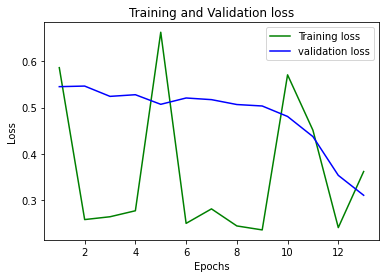

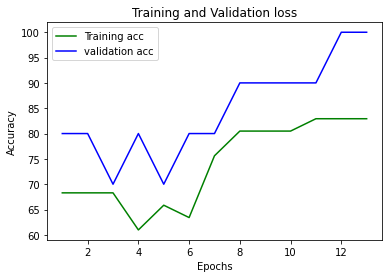

 Training Teacher 14
Epoch: 1 
	Train Loss: 0.401736 	Train Acc: 73.170732 
	Valid Loss: 0.617367 	Valid Acc: 70.000000
Epoch: 2 
	Train Loss: 0.262269 	Train Acc: 80.487805 
	Valid Loss: 0.526833 	Valid Acc: 80.000000
Epoch: 3 
	Train Loss: 1.060493 	Train Acc: 70.731707 
	Valid Loss: 0.533714 	Valid Acc: 80.000000
Epoch: 4 
	Train Loss: 0.238397 	Train Acc: 70.731707 
	Valid Loss: 0.590328 	Valid Acc: 70.000000
Epoch: 5 
	Train Loss: 0.339974 	Train Acc: 78.048780 
	Valid Loss: 0.650694 	Valid Acc: 70.000000
Epoch: 6 
	Train Loss: 0.466773 	Train Acc: 78.048780 
	Valid Loss: 0.696314 	Valid Acc: 60.000000
Epoch: 7 
	Train Loss: 0.489556 	Train Acc: 75.609756 
	Valid Loss: 0.758370 	Valid Acc: 60.000000
Epoch: 8 
	Train Loss: 0.332274 	Train Acc: 73.170732 
	Valid Loss: 0.823488 	Valid Acc: 60.000000
Epoch: 9 
	Train Loss: 0.768670 	Train Acc: 68.292683 
	Valid Loss: 0.817968 	Valid Acc: 60.000000
Epoch: 10 
	Train Loss: 0.320351 	Train Acc: 73.170732 
	Valid Loss: 0.770085 	Valid Acc

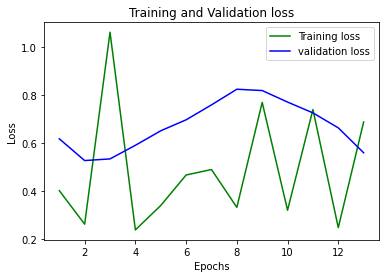

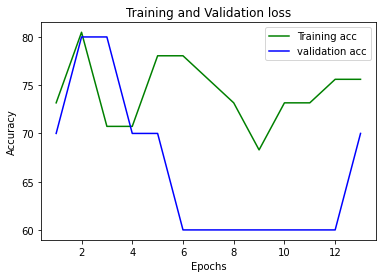

 Training Teacher 15
Epoch: 1 
	Train Loss: 0.217407 	Train Acc: 90.243902 
	Valid Loss: 0.648392 	Valid Acc: 60.000000
Epoch: 2 
	Train Loss: 0.224535 	Train Acc: 87.804878 
	Valid Loss: 0.706158 	Valid Acc: 60.000000
Epoch: 3 
	Train Loss: 0.245796 	Train Acc: 85.365854 
	Valid Loss: 0.702789 	Valid Acc: 60.000000
Epoch: 4 
	Train Loss: 3.546885 	Train Acc: 85.365854 
	Valid Loss: 0.575761 	Valid Acc: 60.000000
Epoch: 5 
	Train Loss: 0.315289 	Train Acc: 85.365854 
	Valid Loss: 0.564231 	Valid Acc: 80.000000
Epoch: 6 
	Train Loss: 0.443450 	Train Acc: 95.121951 
	Valid Loss: 0.575548 	Valid Acc: 80.000000
Epoch: 7 
	Train Loss: 0.447477 	Train Acc: 78.048780 
	Valid Loss: 0.567882 	Valid Acc: 80.000000
Epoch: 8 
	Train Loss: 0.596424 	Train Acc: 73.170732 
	Valid Loss: 0.612145 	Valid Acc: 70.000000
Epoch: 9 
	Train Loss: 0.278547 	Train Acc: 68.292683 
	Valid Loss: 0.611535 	Valid Acc: 70.000000
Epoch: 10 
	Train Loss: 0.334188 	Train Acc: 73.170732 
	Valid Loss: 0.609448 	Valid Acc

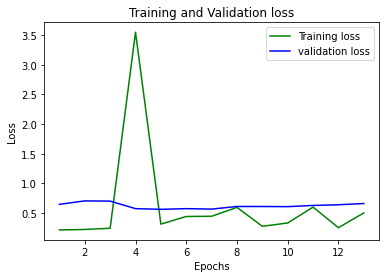

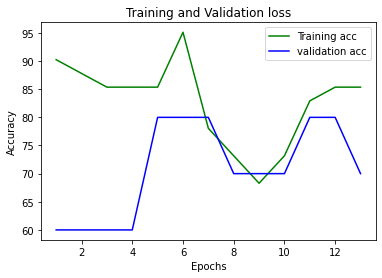

 Training Teacher 16
Epoch: 1 
	Train Loss: 0.508208 	Train Acc: 78.048780 
	Valid Loss: 0.589459 	Valid Acc: 90.000000
Epoch: 2 
	Train Loss: 0.542900 	Train Acc: 82.926829 
	Valid Loss: 0.579524 	Valid Acc: 90.000000
Epoch: 3 
	Train Loss: 0.485017 	Train Acc: 75.609756 
	Valid Loss: 0.561780 	Valid Acc: 80.000000
Epoch: 4 
	Train Loss: 0.357543 	Train Acc: 65.853659 
	Valid Loss: 0.511357 	Valid Acc: 80.000000
Epoch: 5 
	Train Loss: 0.719707 	Train Acc: 63.414634 
	Valid Loss: 0.496029 	Valid Acc: 80.000000
Epoch: 6 
	Train Loss: 0.628460 	Train Acc: 65.853659 
	Valid Loss: 0.513059 	Valid Acc: 80.000000
Epoch: 7 
	Train Loss: 0.364912 	Train Acc: 80.487805 
	Valid Loss: 0.503584 	Valid Acc: 80.000000
Epoch: 8 
	Train Loss: 0.379386 	Train Acc: 85.365854 
	Valid Loss: 0.482838 	Valid Acc: 80.000000
Epoch: 9 
	Train Loss: 0.263226 	Train Acc: 87.804878 
	Valid Loss: 0.489000 	Valid Acc: 80.000000
Epoch: 10 
	Train Loss: 0.455475 	Train Acc: 82.926829 
	Valid Loss: 0.447418 	Valid Acc

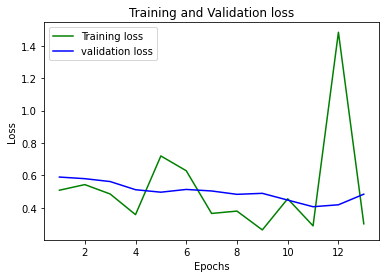

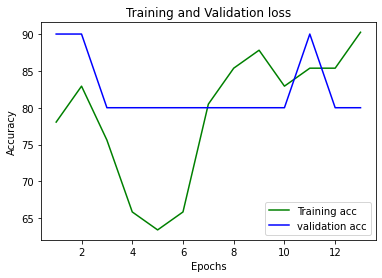

 Training Teacher 17
Epoch: 1 
	Train Loss: 0.294070 	Train Acc: 73.170732 
	Valid Loss: 0.394330 	Valid Acc: 80.000000
Epoch: 2 
	Train Loss: 0.359129 	Train Acc: 78.048780 
	Valid Loss: 0.419952 	Valid Acc: 70.000000
Epoch: 3 
	Train Loss: 0.789804 	Train Acc: 78.048780 
	Valid Loss: 0.422324 	Valid Acc: 70.000000
Epoch: 4 
	Train Loss: 0.882530 	Train Acc: 78.048780 
	Valid Loss: 0.380563 	Valid Acc: 80.000000
Epoch: 5 
	Train Loss: 0.343942 	Train Acc: 75.609756 
	Valid Loss: 0.372432 	Valid Acc: 80.000000
Epoch: 6 
	Train Loss: 0.395973 	Train Acc: 82.926829 
	Valid Loss: 0.386502 	Valid Acc: 90.000000
Epoch: 7 
	Train Loss: 0.529469 	Train Acc: 85.365854 
	Valid Loss: 0.402436 	Valid Acc: 90.000000
Epoch: 8 
	Train Loss: 0.353439 	Train Acc: 82.926829 
	Valid Loss: 0.422376 	Valid Acc: 90.000000
Epoch: 9 
	Train Loss: 0.335482 	Train Acc: 80.487805 
	Valid Loss: 0.421372 	Valid Acc: 80.000000
Epoch: 10 
	Train Loss: 0.269371 	Train Acc: 82.926829 
	Valid Loss: 0.430273 	Valid Acc

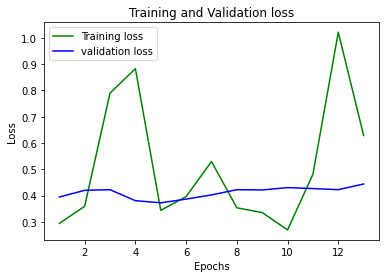

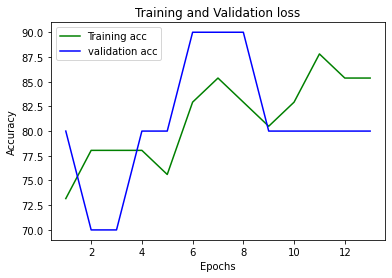

 Training Teacher 18
Epoch: 1 
	Train Loss: 0.343068 	Train Acc: 80.487805 
	Valid Loss: 0.430650 	Valid Acc: 80.000000
Epoch: 2 
	Train Loss: 0.614055 	Train Acc: 80.487805 
	Valid Loss: 0.413882 	Valid Acc: 80.000000
Epoch: 3 
	Train Loss: 0.344031 	Train Acc: 78.048780 
	Valid Loss: 0.406167 	Valid Acc: 80.000000
Epoch: 4 
	Train Loss: 0.417719 	Train Acc: 78.048780 
	Valid Loss: 0.387713 	Valid Acc: 80.000000
Epoch: 5 
	Train Loss: 0.309564 	Train Acc: 78.048780 
	Valid Loss: 0.368854 	Valid Acc: 80.000000
Epoch: 6 
	Train Loss: 0.572575 	Train Acc: 75.609756 
	Valid Loss: 0.354006 	Valid Acc: 80.000000
Epoch: 7 
	Train Loss: 0.343826 	Train Acc: 75.609756 
	Valid Loss: 0.346579 	Valid Acc: 80.000000
Epoch: 8 
	Train Loss: 0.683956 	Train Acc: 78.048780 
	Valid Loss: 0.352023 	Valid Acc: 80.000000
Epoch: 9 
	Train Loss: 1.150344 	Train Acc: 73.170732 
	Valid Loss: 0.321697 	Valid Acc: 80.000000
Epoch: 10 
	Train Loss: 0.254933 	Train Acc: 78.048780 
	Valid Loss: 0.301790 	Valid Acc

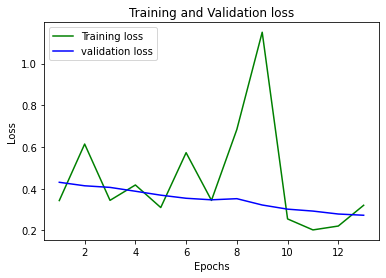

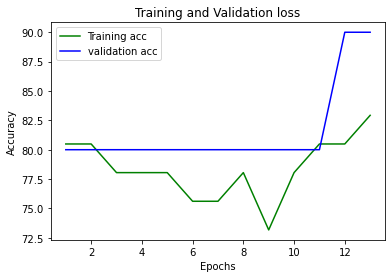

 Training Teacher 19
Epoch: 1 
	Train Loss: 0.562044 	Train Acc: 68.292683 
	Valid Loss: 0.622093 	Valid Acc: 70.000000
Epoch: 2 
	Train Loss: 0.389771 	Train Acc: 70.731707 
	Valid Loss: 0.641789 	Valid Acc: 40.000000
Epoch: 3 
	Train Loss: 1.186656 	Train Acc: 75.609756 
	Valid Loss: 0.646081 	Valid Acc: 60.000000
Epoch: 4 
	Train Loss: 0.259021 	Train Acc: 78.048780 
	Valid Loss: 0.648038 	Valid Acc: 50.000000
Epoch: 5 
	Train Loss: 0.331679 	Train Acc: 80.487805 
	Valid Loss: 0.673728 	Valid Acc: 60.000000
Epoch: 6 
	Train Loss: 0.442289 	Train Acc: 85.365854 
	Valid Loss: 0.639206 	Valid Acc: 60.000000
Epoch: 7 
	Train Loss: 0.208101 	Train Acc: 85.365854 
	Valid Loss: 0.635147 	Valid Acc: 60.000000
Epoch: 8 
	Train Loss: 0.413746 	Train Acc: 80.487805 
	Valid Loss: 0.625778 	Valid Acc: 60.000000
Epoch: 9 
	Train Loss: 0.212505 	Train Acc: 87.804878 
	Valid Loss: 0.747982 	Valid Acc: 70.000000
Epoch: 10 
	Train Loss: 0.377793 	Train Acc: 87.804878 
	Valid Loss: 0.805115 	Valid Acc

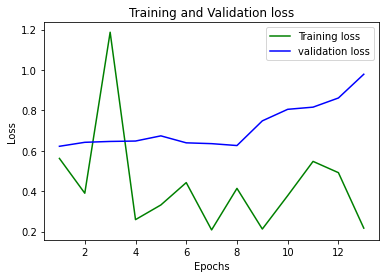

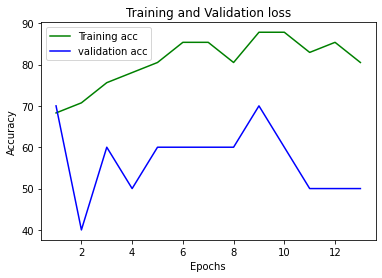

 Training Teacher 20
Epoch: 1 
	Train Loss: 0.596878 	Train Acc: 65.853659 
	Valid Loss: 0.762066 	Valid Acc: 70.000000
Epoch: 2 
	Train Loss: 0.408860 	Train Acc: 70.731707 
	Valid Loss: 0.774617 	Valid Acc: 70.000000
Epoch: 3 
	Train Loss: 0.663325 	Train Acc: 70.731707 
	Valid Loss: 0.821893 	Valid Acc: 70.000000
Epoch: 4 
	Train Loss: 0.621710 	Train Acc: 70.731707 
	Valid Loss: 0.861394 	Valid Acc: 70.000000
Epoch: 5 
	Train Loss: 0.788821 	Train Acc: 68.292683 
	Valid Loss: 0.916155 	Valid Acc: 70.000000
Epoch: 6 
	Train Loss: 0.686866 	Train Acc: 73.170732 
	Valid Loss: 0.911711 	Valid Acc: 70.000000
Epoch: 7 
	Train Loss: 0.284754 	Train Acc: 75.609756 
	Valid Loss: 0.954659 	Valid Acc: 70.000000
Epoch: 8 
	Train Loss: 0.851916 	Train Acc: 73.170732 
	Valid Loss: 0.995734 	Valid Acc: 70.000000
Epoch: 9 
	Train Loss: 0.265539 	Train Acc: 75.609756 
	Valid Loss: 1.055132 	Valid Acc: 70.000000
Epoch: 10 
	Train Loss: 0.246580 	Train Acc: 80.487805 
	Valid Loss: 1.069749 	Valid Acc

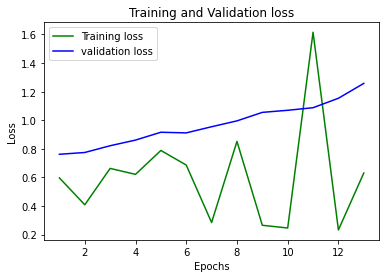

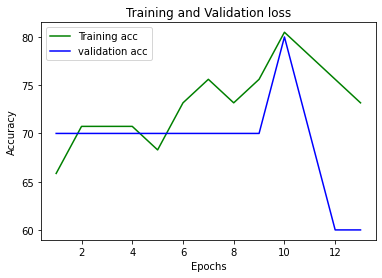

 Training Teacher 21
Epoch: 1 
	Train Loss: 0.279225 	Train Acc: 78.048780 
	Valid Loss: 0.266565 	Valid Acc: 80.000000
Epoch: 2 
	Train Loss: 1.883053 	Train Acc: 82.926829 
	Valid Loss: 0.305694 	Valid Acc: 80.000000
Epoch: 3 
	Train Loss: 0.302960 	Train Acc: 82.926829 
	Valid Loss: 0.294116 	Valid Acc: 80.000000
Epoch: 4 
	Train Loss: 0.187576 	Train Acc: 80.487805 
	Valid Loss: 0.311561 	Valid Acc: 80.000000
Epoch: 5 
	Train Loss: 0.313972 	Train Acc: 80.487805 
	Valid Loss: 0.340871 	Valid Acc: 80.000000
Epoch: 6 
	Train Loss: 0.361311 	Train Acc: 82.926829 
	Valid Loss: 0.323250 	Valid Acc: 80.000000
Epoch: 7 
	Train Loss: 0.906683 	Train Acc: 78.048780 
	Valid Loss: 0.353832 	Valid Acc: 80.000000
Epoch: 8 
	Train Loss: 1.623973 	Train Acc: 73.170732 
	Valid Loss: 0.356275 	Valid Acc: 80.000000
Epoch: 9 
	Train Loss: 0.393869 	Train Acc: 80.487805 
	Valid Loss: 0.353693 	Valid Acc: 80.000000
Epoch: 10 
	Train Loss: 0.344121 	Train Acc: 70.731707 
	Valid Loss: 0.354602 	Valid Acc

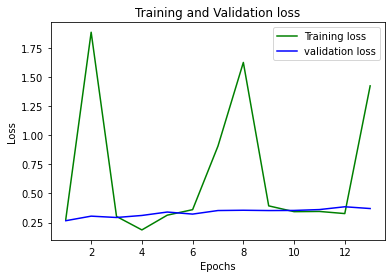

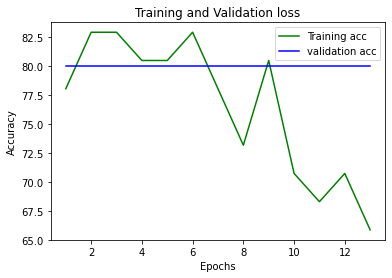

 Training Teacher 22
Epoch: 1 
	Train Loss: 1.142496 	Train Acc: 56.097561 
	Valid Loss: 0.906154 	Valid Acc: 40.000000
Epoch: 2 
	Train Loss: 1.174323 	Train Acc: 53.658537 
	Valid Loss: 0.673869 	Valid Acc: 50.000000
Epoch: 3 
	Train Loss: 0.412650 	Train Acc: 78.048780 
	Valid Loss: 0.422356 	Valid Acc: 80.000000
Epoch: 4 
	Train Loss: 1.533221 	Train Acc: 48.780488 
	Valid Loss: 0.615792 	Valid Acc: 70.000000
Epoch: 5 
	Train Loss: 0.425723 	Train Acc: 70.731707 
	Valid Loss: 0.664607 	Valid Acc: 70.000000
Epoch: 6 
	Train Loss: 0.373779 	Train Acc: 60.975610 
	Valid Loss: 0.654355 	Valid Acc: 60.000000
Epoch: 7 
	Train Loss: 0.368826 	Train Acc: 73.170732 
	Valid Loss: 0.638332 	Valid Acc: 60.000000
Epoch: 8 
	Train Loss: 0.302005 	Train Acc: 68.292683 
	Valid Loss: 0.631349 	Valid Acc: 60.000000
Epoch: 9 
	Train Loss: 0.428730 	Train Acc: 65.853659 
	Valid Loss: 0.593173 	Valid Acc: 50.000000
Epoch: 10 
	Train Loss: 0.329869 	Train Acc: 65.853659 
	Valid Loss: 0.515349 	Valid Acc

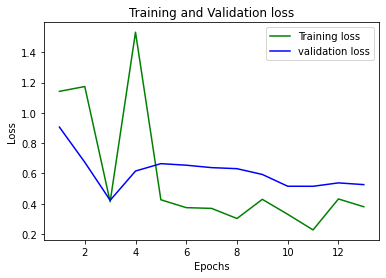

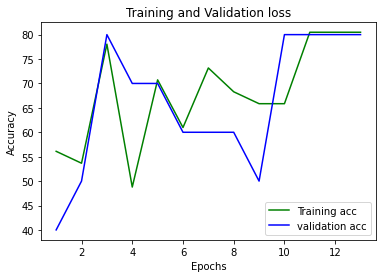

 Training Teacher 23
Epoch: 1 
	Train Loss: 0.734796 	Train Acc: 56.097561 
	Valid Loss: 0.395761 	Valid Acc: 70.000000
Epoch: 2 
	Train Loss: 0.383907 	Train Acc: 63.414634 
	Valid Loss: 0.509179 	Valid Acc: 80.000000
Epoch: 3 
	Train Loss: 0.884154 	Train Acc: 63.414634 
	Valid Loss: 0.467130 	Valid Acc: 80.000000
Epoch: 4 
	Train Loss: 0.822631 	Train Acc: 63.414634 
	Valid Loss: 0.403912 	Valid Acc: 90.000000
Epoch: 5 
	Train Loss: 0.730886 	Train Acc: 68.292683 
	Valid Loss: 0.438116 	Valid Acc: 90.000000
Epoch: 6 
	Train Loss: 0.299882 	Train Acc: 75.609756 
	Valid Loss: 0.433140 	Valid Acc: 70.000000
Epoch: 7 
	Train Loss: 0.548444 	Train Acc: 73.170732 
	Valid Loss: 0.443776 	Valid Acc: 70.000000
Epoch: 8 
	Train Loss: 0.601941 	Train Acc: 65.853659 
	Valid Loss: 0.466208 	Valid Acc: 70.000000
Epoch: 9 
	Train Loss: 0.673810 	Train Acc: 65.853659 
	Valid Loss: 0.470438 	Valid Acc: 70.000000
Epoch: 10 
	Train Loss: 0.463999 	Train Acc: 73.170732 
	Valid Loss: 0.517268 	Valid Acc

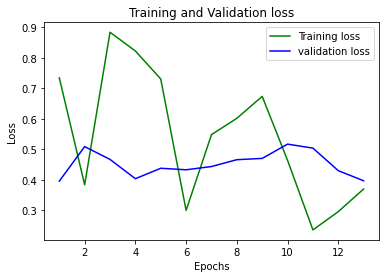

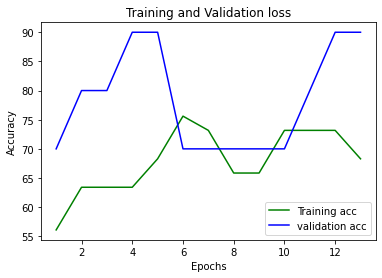

 Training Teacher 24
Epoch: 1 
	Train Loss: 1.506753 	Train Acc: 65.853659 
	Valid Loss: 0.544995 	Valid Acc: 70.000000
Epoch: 2 
	Train Loss: 0.335550 	Train Acc: 63.414634 
	Valid Loss: 0.508375 	Valid Acc: 80.000000
Epoch: 3 
	Train Loss: 0.403732 	Train Acc: 63.414634 
	Valid Loss: 0.517994 	Valid Acc: 70.000000
Epoch: 4 
	Train Loss: 0.351702 	Train Acc: 63.414634 
	Valid Loss: 0.531450 	Valid Acc: 70.000000
Epoch: 5 
	Train Loss: 1.068440 	Train Acc: 65.853659 
	Valid Loss: 0.586450 	Valid Acc: 60.000000
Epoch: 6 
	Train Loss: 0.643856 	Train Acc: 65.853659 
	Valid Loss: 0.612778 	Valid Acc: 60.000000
Epoch: 7 
	Train Loss: 0.615080 	Train Acc: 70.731707 
	Valid Loss: 0.620223 	Valid Acc: 70.000000
Epoch: 8 
	Train Loss: 0.678358 	Train Acc: 70.731707 
	Valid Loss: 0.634448 	Valid Acc: 50.000000
Epoch: 9 
	Train Loss: 0.544565 	Train Acc: 75.609756 
	Valid Loss: 0.638552 	Valid Acc: 50.000000
Epoch: 10 
	Train Loss: 0.495343 	Train Acc: 73.170732 
	Valid Loss: 0.637754 	Valid Acc

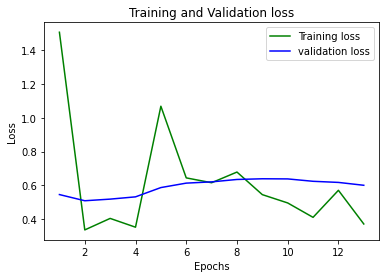

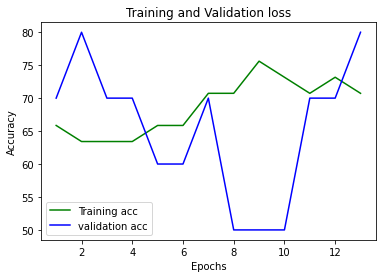

 Training Teacher 25
Epoch: 1 
	Train Loss: 0.237391 	Train Acc: 78.048780 
	Valid Loss: 0.545670 	Valid Acc: 80.000000
Epoch: 2 
	Train Loss: 0.227594 	Train Acc: 80.487805 
	Valid Loss: 0.537447 	Valid Acc: 80.000000
Epoch: 3 
	Train Loss: 0.315904 	Train Acc: 78.048780 
	Valid Loss: 0.538328 	Valid Acc: 80.000000
Epoch: 4 
	Train Loss: 0.358971 	Train Acc: 80.487805 
	Valid Loss: 0.521123 	Valid Acc: 80.000000
Epoch: 5 
	Train Loss: 0.524377 	Train Acc: 82.926829 
	Valid Loss: 0.519220 	Valid Acc: 80.000000
Epoch: 6 
	Train Loss: 0.400522 	Train Acc: 82.926829 
	Valid Loss: 0.506670 	Valid Acc: 80.000000
Epoch: 7 
	Train Loss: 0.467508 	Train Acc: 82.926829 
	Valid Loss: 0.504479 	Valid Acc: 80.000000
Epoch: 8 
	Train Loss: 0.677099 	Train Acc: 80.487805 
	Valid Loss: 0.500577 	Valid Acc: 90.000000
Epoch: 9 
	Train Loss: 0.514840 	Train Acc: 80.487805 
	Valid Loss: 0.495404 	Valid Acc: 90.000000
Epoch: 10 
	Train Loss: 0.489305 	Train Acc: 78.048780 
	Valid Loss: 0.497846 	Valid Acc

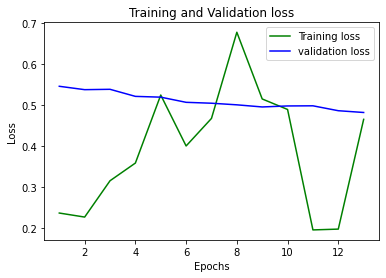

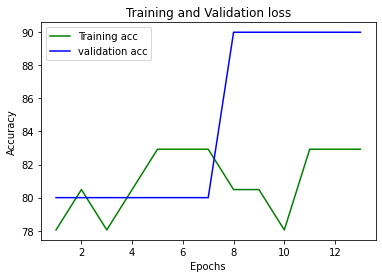

 Training Teacher 26
Epoch: 1 
	Train Loss: 0.528274 	Train Acc: 70.731707 
	Valid Loss: 0.614695 	Valid Acc: 50.000000
Epoch: 2 
	Train Loss: 0.516366 	Train Acc: 70.731707 
	Valid Loss: 0.597751 	Valid Acc: 50.000000
Epoch: 3 
	Train Loss: 1.633233 	Train Acc: 70.731707 
	Valid Loss: 0.561145 	Valid Acc: 50.000000
Epoch: 4 
	Train Loss: 0.526874 	Train Acc: 75.609756 
	Valid Loss: 0.560237 	Valid Acc: 70.000000
Epoch: 5 
	Train Loss: 0.598688 	Train Acc: 68.292683 
	Valid Loss: 0.575116 	Valid Acc: 60.000000
Epoch: 6 
	Train Loss: 0.525328 	Train Acc: 82.926829 
	Valid Loss: 0.576103 	Valid Acc: 80.000000
Epoch: 7 
	Train Loss: 0.583035 	Train Acc: 80.487805 
	Valid Loss: 0.570809 	Valid Acc: 70.000000
Epoch: 8 
	Train Loss: 0.707498 	Train Acc: 82.926829 
	Valid Loss: 0.570891 	Valid Acc: 70.000000
Epoch: 9 
	Train Loss: 0.328334 	Train Acc: 85.365854 
	Valid Loss: 0.594789 	Valid Acc: 70.000000
Epoch: 10 
	Train Loss: 0.536563 	Train Acc: 78.048780 
	Valid Loss: 0.584663 	Valid Acc

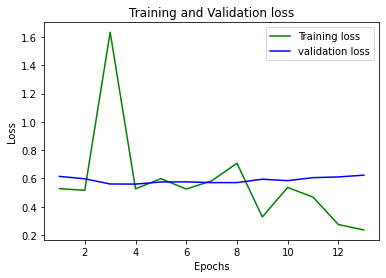

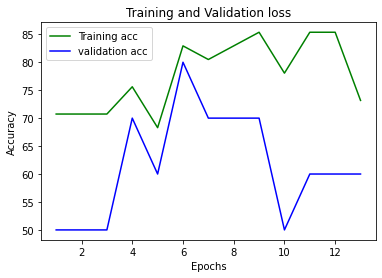

 Training Teacher 27
Epoch: 1 
	Train Loss: 0.612725 	Train Acc: 87.804878 
	Valid Loss: 0.443812 	Valid Acc: 70.000000
Epoch: 2 
	Train Loss: 0.484652 	Train Acc: 87.804878 
	Valid Loss: 0.416634 	Valid Acc: 70.000000
Epoch: 3 
	Train Loss: 0.383764 	Train Acc: 90.243902 
	Valid Loss: 0.384491 	Valid Acc: 70.000000
Epoch: 4 
	Train Loss: 0.314881 	Train Acc: 92.682927 
	Valid Loss: 0.365056 	Valid Acc: 90.000000
Epoch: 5 
	Train Loss: 0.220021 	Train Acc: 92.682927 
	Valid Loss: 0.347457 	Valid Acc: 90.000000
Epoch: 6 
	Train Loss: 0.923449 	Train Acc: 87.804878 
	Valid Loss: 0.316850 	Valid Acc: 90.000000
Epoch: 7 
	Train Loss: 0.151581 	Train Acc: 90.243902 
	Valid Loss: 0.323922 	Valid Acc: 90.000000
Epoch: 8 
	Train Loss: 0.147276 	Train Acc: 87.804878 
	Valid Loss: 0.310295 	Valid Acc: 90.000000
Epoch: 9 
	Train Loss: 0.130571 	Train Acc: 92.682927 
	Valid Loss: 0.286349 	Valid Acc: 90.000000
Epoch: 10 
	Train Loss: 0.222288 	Train Acc: 92.682927 
	Valid Loss: 0.305526 	Valid Acc

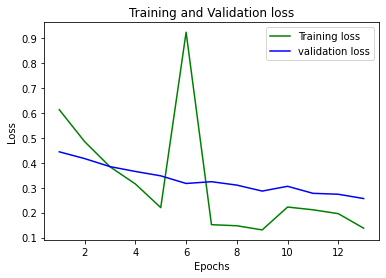

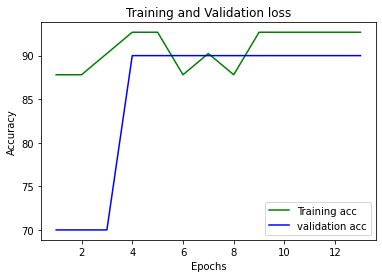

 Training Teacher 28
Epoch: 1 
	Train Loss: 0.350954 	Train Acc: 68.292683 
	Valid Loss: 0.675883 	Valid Acc: 60.000000
Epoch: 2 
	Train Loss: 0.550647 	Train Acc: 75.609756 
	Valid Loss: 0.658060 	Valid Acc: 70.000000
Epoch: 3 
	Train Loss: 0.344344 	Train Acc: 70.731707 
	Valid Loss: 0.645009 	Valid Acc: 70.000000
Epoch: 4 
	Train Loss: 0.337543 	Train Acc: 73.170732 
	Valid Loss: 0.615106 	Valid Acc: 70.000000
Epoch: 5 
	Train Loss: 0.347256 	Train Acc: 75.609756 
	Valid Loss: 0.590803 	Valid Acc: 60.000000
Epoch: 6 
	Train Loss: 0.292371 	Train Acc: 78.048780 
	Valid Loss: 0.651387 	Valid Acc: 60.000000
Epoch: 7 
	Train Loss: 0.268936 	Train Acc: 75.609756 
	Valid Loss: 0.566481 	Valid Acc: 60.000000
Epoch: 8 
	Train Loss: 0.466261 	Train Acc: 78.048780 
	Valid Loss: 0.586075 	Valid Acc: 60.000000
Epoch: 9 
	Train Loss: 0.272980 	Train Acc: 80.487805 
	Valid Loss: 0.669899 	Valid Acc: 60.000000
Epoch: 10 
	Train Loss: 0.221002 	Train Acc: 80.487805 
	Valid Loss: 0.678475 	Valid Acc

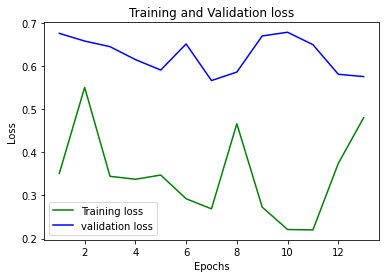

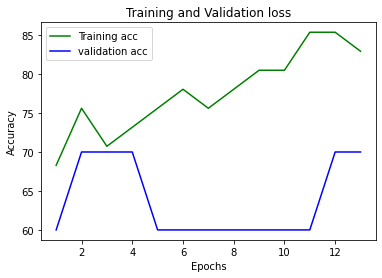

 Training Teacher 29
Epoch: 1 
	Train Loss: 1.674732 	Train Acc: 78.048780 
	Valid Loss: 0.375374 	Valid Acc: 80.000000
Epoch: 2 
	Train Loss: 0.296256 	Train Acc: 87.804878 
	Valid Loss: 0.494943 	Valid Acc: 70.000000
Epoch: 3 
	Train Loss: 0.256364 	Train Acc: 85.365854 
	Valid Loss: 0.728198 	Valid Acc: 70.000000
Epoch: 4 
	Train Loss: 0.269687 	Train Acc: 78.048780 
	Valid Loss: 0.918715 	Valid Acc: 70.000000
Epoch: 5 
	Train Loss: 0.302729 	Train Acc: 73.170732 
	Valid Loss: 1.030603 	Valid Acc: 70.000000
Epoch: 6 
	Train Loss: 0.615794 	Train Acc: 78.048780 
	Valid Loss: 1.031718 	Valid Acc: 70.000000
Epoch: 7 
	Train Loss: 0.479639 	Train Acc: 75.609756 
	Valid Loss: 0.765154 	Valid Acc: 60.000000
Epoch: 8 
	Train Loss: 0.215517 	Train Acc: 85.365854 
	Valid Loss: 0.784126 	Valid Acc: 60.000000
Epoch: 9 
	Train Loss: 0.203244 	Train Acc: 85.365854 
	Valid Loss: 1.041108 	Valid Acc: 50.000000
Epoch: 10 
	Train Loss: 0.289444 	Train Acc: 82.926829 
	Valid Loss: 0.849240 	Valid Acc

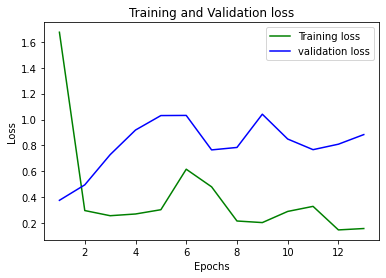

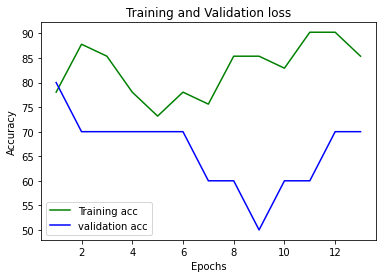

 Training Teacher 30
Epoch: 1 
	Train Loss: 0.266150 	Train Acc: 68.292683 
	Valid Loss: 0.313232 	Valid Acc: 90.000000
Epoch: 2 
	Train Loss: 0.269481 	Train Acc: 70.731707 
	Valid Loss: 0.309961 	Valid Acc: 90.000000
Epoch: 3 
	Train Loss: 1.851040 	Train Acc: 73.170732 
	Valid Loss: 0.284778 	Valid Acc: 80.000000
Epoch: 4 
	Train Loss: 0.546620 	Train Acc: 75.609756 
	Valid Loss: 0.228247 	Valid Acc: 100.000000
Epoch: 5 
	Train Loss: 0.333689 	Train Acc: 73.170732 
	Valid Loss: 0.244428 	Valid Acc: 90.000000
Epoch: 6 
	Train Loss: 0.310906 	Train Acc: 78.048780 
	Valid Loss: 0.323871 	Valid Acc: 90.000000
Epoch: 7 
	Train Loss: 0.368263 	Train Acc: 73.170732 
	Valid Loss: 0.411618 	Valid Acc: 90.000000
Epoch: 8 
	Train Loss: 0.371904 	Train Acc: 70.731707 
	Valid Loss: 0.447420 	Valid Acc: 90.000000
Epoch: 9 
	Train Loss: 0.464222 	Train Acc: 70.731707 
	Valid Loss: 0.451205 	Valid Acc: 90.000000
Epoch: 10 
	Train Loss: 0.748102 	Train Acc: 78.048780 
	Valid Loss: 0.464333 	Valid Ac

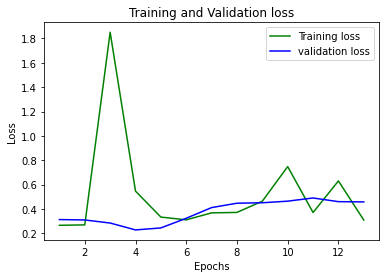

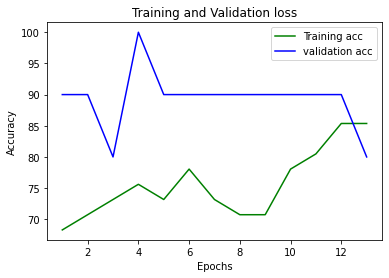

 Training Teacher 31
Epoch: 1 
	Train Loss: 0.336448 	Train Acc: 82.926829 
	Valid Loss: 0.569177 	Valid Acc: 60.000000
Epoch: 2 
	Train Loss: 0.352988 	Train Acc: 82.926829 
	Valid Loss: 0.552773 	Valid Acc: 60.000000
Epoch: 3 
	Train Loss: 0.215933 	Train Acc: 85.365854 
	Valid Loss: 0.595149 	Valid Acc: 60.000000
Epoch: 4 
	Train Loss: 0.224904 	Train Acc: 82.926829 
	Valid Loss: 0.621647 	Valid Acc: 60.000000
Epoch: 5 
	Train Loss: 0.197773 	Train Acc: 80.487805 
	Valid Loss: 0.641898 	Valid Acc: 50.000000
Epoch: 6 
	Train Loss: 0.272508 	Train Acc: 82.926829 
	Valid Loss: 0.667766 	Valid Acc: 50.000000
Epoch: 7 
	Train Loss: 0.207849 	Train Acc: 82.926829 
	Valid Loss: 0.654567 	Valid Acc: 70.000000
Epoch: 8 
	Train Loss: 0.251888 	Train Acc: 82.926829 
	Valid Loss: 0.651145 	Valid Acc: 70.000000
Epoch: 9 
	Train Loss: 0.458748 	Train Acc: 82.926829 
	Valid Loss: 0.649700 	Valid Acc: 70.000000
Epoch: 10 
	Train Loss: 0.180944 	Train Acc: 80.487805 
	Valid Loss: 0.639757 	Valid Acc

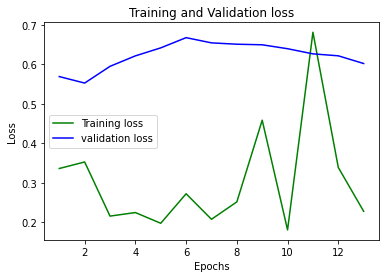

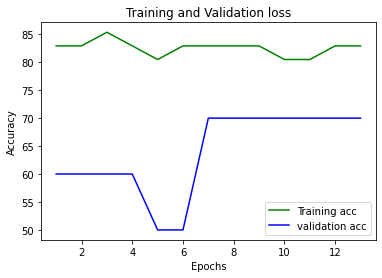

 Training Teacher 32
Epoch: 1 
	Train Loss: 0.563424 	Train Acc: 70.731707 
	Valid Loss: 0.589451 	Valid Acc: 70.000000
Epoch: 2 
	Train Loss: 1.435560 	Train Acc: 70.731707 
	Valid Loss: 0.571785 	Valid Acc: 70.000000
Epoch: 3 
	Train Loss: 0.762181 	Train Acc: 70.731707 
	Valid Loss: 0.516706 	Valid Acc: 60.000000
Epoch: 4 
	Train Loss: 0.933917 	Train Acc: 73.170732 
	Valid Loss: 0.489779 	Valid Acc: 60.000000
Epoch: 5 
	Train Loss: 0.458127 	Train Acc: 75.609756 
	Valid Loss: 0.529725 	Valid Acc: 70.000000
Epoch: 6 
	Train Loss: 0.311984 	Train Acc: 78.048780 
	Valid Loss: 0.605703 	Valid Acc: 70.000000
Epoch: 7 
	Train Loss: 0.258417 	Train Acc: 75.609756 
	Valid Loss: 0.629605 	Valid Acc: 70.000000
Epoch: 8 
	Train Loss: 0.322882 	Train Acc: 75.609756 
	Valid Loss: 0.571662 	Valid Acc: 70.000000
Epoch: 9 
	Train Loss: 0.285606 	Train Acc: 75.609756 
	Valid Loss: 0.543178 	Valid Acc: 70.000000
Epoch: 10 
	Train Loss: 0.579169 	Train Acc: 75.609756 
	Valid Loss: 0.537715 	Valid Acc

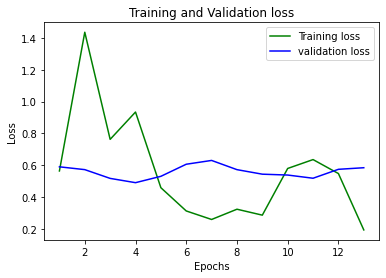

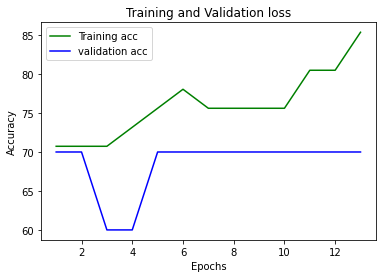

 Training Teacher 33
Epoch: 1 
	Train Loss: 0.541760 	Train Acc: 75.609756 
	Valid Loss: 0.606652 	Valid Acc: 60.000000
Epoch: 2 
	Train Loss: 0.530048 	Train Acc: 75.609756 
	Valid Loss: 0.559926 	Valid Acc: 60.000000
Epoch: 3 
	Train Loss: 0.568912 	Train Acc: 82.926829 
	Valid Loss: 0.610737 	Valid Acc: 60.000000
Epoch: 4 
	Train Loss: 0.195159 	Train Acc: 87.804878 
	Valid Loss: 0.676231 	Valid Acc: 70.000000
Epoch: 5 
	Train Loss: 0.216607 	Train Acc: 92.682927 
	Valid Loss: 0.679544 	Valid Acc: 70.000000
Epoch: 6 
	Train Loss: 0.303854 	Train Acc: 87.804878 
	Valid Loss: 0.526678 	Valid Acc: 60.000000
Epoch: 7 
	Train Loss: 0.087952 	Train Acc: 92.682927 
	Valid Loss: 0.545837 	Valid Acc: 80.000000
Epoch: 8 
	Train Loss: 0.271593 	Train Acc: 90.243902 
	Valid Loss: 0.772482 	Valid Acc: 60.000000
Epoch: 9 
	Train Loss: 1.078948 	Train Acc: 82.926829 
	Valid Loss: 0.816777 	Valid Acc: 90.000000
Epoch: 10 
	Train Loss: 0.280359 	Train Acc: 82.926829 
	Valid Loss: 1.668604 	Valid Acc

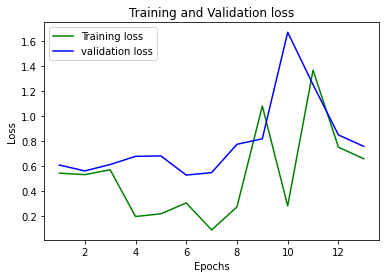

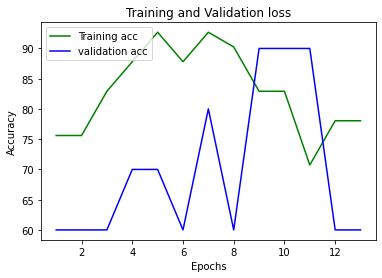

 Training Teacher 34
Epoch: 1 
	Train Loss: 4.460017 	Train Acc: 78.048780 
	Valid Loss: 0.726135 	Valid Acc: 60.000000
Epoch: 2 
	Train Loss: 0.982982 	Train Acc: 80.487805 
	Valid Loss: 0.516251 	Valid Acc: 60.000000
Epoch: 3 
	Train Loss: 0.348252 	Train Acc: 78.048780 
	Valid Loss: 0.531166 	Valid Acc: 70.000000
Epoch: 4 
	Train Loss: 1.419748 	Train Acc: 80.487805 
	Valid Loss: 0.539194 	Valid Acc: 70.000000
Epoch: 5 
	Train Loss: 0.550043 	Train Acc: 80.487805 
	Valid Loss: 0.539258 	Valid Acc: 70.000000
Epoch: 6 
	Train Loss: 0.445591 	Train Acc: 78.048780 
	Valid Loss: 0.536743 	Valid Acc: 70.000000
Epoch: 7 
	Train Loss: 0.423940 	Train Acc: 73.170732 
	Valid Loss: 0.520499 	Valid Acc: 80.000000
Epoch: 8 
	Train Loss: 0.884072 	Train Acc: 70.731707 
	Valid Loss: 0.536267 	Valid Acc: 80.000000
Epoch: 9 
	Train Loss: 0.641970 	Train Acc: 68.292683 
	Valid Loss: 0.530123 	Valid Acc: 70.000000
Epoch: 10 
	Train Loss: 0.899524 	Train Acc: 75.609756 
	Valid Loss: 0.556017 	Valid Acc

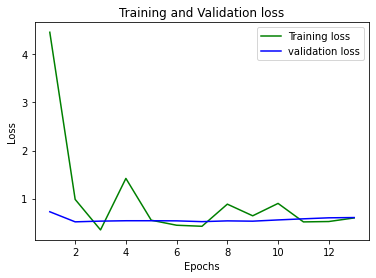

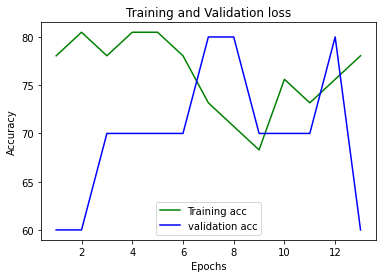

 Training Teacher 35
Epoch: 1 
	Train Loss: 0.549245 	Train Acc: 78.048780 
	Valid Loss: 0.668528 	Valid Acc: 60.000000
Epoch: 2 
	Train Loss: 0.516908 	Train Acc: 78.048780 
	Valid Loss: 0.660660 	Valid Acc: 70.000000
Epoch: 3 
	Train Loss: 0.369582 	Train Acc: 78.048780 
	Valid Loss: 0.623096 	Valid Acc: 60.000000
Epoch: 4 
	Train Loss: 0.484376 	Train Acc: 78.048780 
	Valid Loss: 0.584445 	Valid Acc: 60.000000
Epoch: 5 
	Train Loss: 0.337069 	Train Acc: 78.048780 
	Valid Loss: 0.560777 	Valid Acc: 60.000000
Epoch: 6 
	Train Loss: 0.566549 	Train Acc: 75.609756 
	Valid Loss: 0.524888 	Valid Acc: 80.000000
Epoch: 7 
	Train Loss: 0.306704 	Train Acc: 75.609756 
	Valid Loss: 0.485757 	Valid Acc: 90.000000
Epoch: 8 
	Train Loss: 0.645373 	Train Acc: 75.609756 
	Valid Loss: 0.388570 	Valid Acc: 80.000000
Epoch: 9 
	Train Loss: 0.513920 	Train Acc: 75.609756 
	Valid Loss: 0.331054 	Valid Acc: 80.000000
Epoch: 10 
	Train Loss: 1.567873 	Train Acc: 75.609756 
	Valid Loss: 0.303302 	Valid Acc

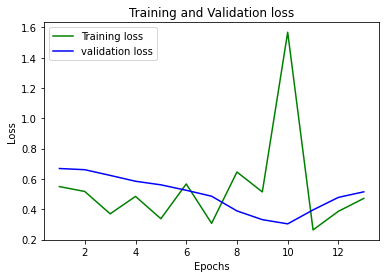

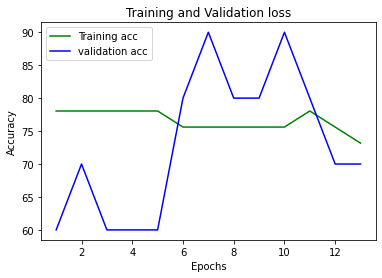

 Training Teacher 36
Epoch: 1 
	Train Loss: 2.585656 	Train Acc: 68.292683 
	Valid Loss: 0.966321 	Valid Acc: 40.000000
Epoch: 2 
	Train Loss: 0.499656 	Train Acc: 70.731707 
	Valid Loss: 0.625495 	Valid Acc: 60.000000
Epoch: 3 
	Train Loss: 0.281040 	Train Acc: 80.487805 
	Valid Loss: 0.571881 	Valid Acc: 70.000000
Epoch: 4 
	Train Loss: 0.305554 	Train Acc: 80.487805 
	Valid Loss: 0.579020 	Valid Acc: 80.000000
Epoch: 5 
	Train Loss: 0.313956 	Train Acc: 82.926829 
	Valid Loss: 0.576892 	Valid Acc: 70.000000
Epoch: 6 
	Train Loss: 0.420904 	Train Acc: 82.926829 
	Valid Loss: 0.559995 	Valid Acc: 80.000000
Epoch: 7 
	Train Loss: 0.254440 	Train Acc: 85.365854 
	Valid Loss: 0.555428 	Valid Acc: 70.000000
Epoch: 8 
	Train Loss: 0.480768 	Train Acc: 90.243902 
	Valid Loss: 0.505717 	Valid Acc: 70.000000
Epoch: 9 
	Train Loss: 0.442070 	Train Acc: 87.804878 
	Valid Loss: 0.485300 	Valid Acc: 80.000000
Epoch: 10 
	Train Loss: 0.243004 	Train Acc: 85.365854 
	Valid Loss: 0.519843 	Valid Acc

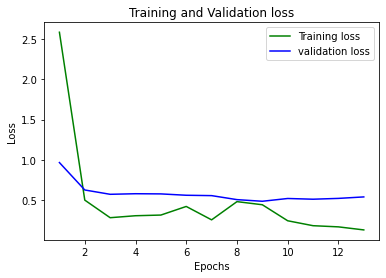

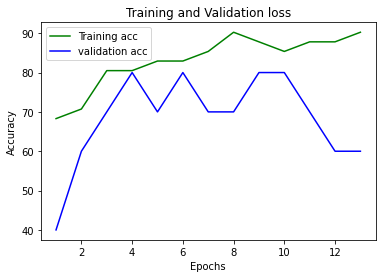

 Training Teacher 37
Epoch: 1 
	Train Loss: 0.265459 	Train Acc: 70.731707 
	Valid Loss: 0.536004 	Valid Acc: 70.000000
Epoch: 2 
	Train Loss: 0.829686 	Train Acc: 70.731707 
	Valid Loss: 0.598895 	Valid Acc: 70.000000
Epoch: 3 
	Train Loss: 1.157203 	Train Acc: 78.048780 
	Valid Loss: 0.578265 	Valid Acc: 70.000000
Epoch: 4 
	Train Loss: 1.228823 	Train Acc: 73.170732 
	Valid Loss: 0.558105 	Valid Acc: 60.000000
Epoch: 5 
	Train Loss: 0.479303 	Train Acc: 73.170732 
	Valid Loss: 0.550349 	Valid Acc: 70.000000
Epoch: 6 
	Train Loss: 0.284679 	Train Acc: 75.609756 
	Valid Loss: 0.508345 	Valid Acc: 60.000000
Epoch: 7 
	Train Loss: 2.600352 	Train Acc: 70.731707 
	Valid Loss: 0.522922 	Valid Acc: 70.000000
Epoch: 8 
	Train Loss: 0.707920 	Train Acc: 73.170732 
	Valid Loss: 0.631136 	Valid Acc: 50.000000
Epoch: 9 
	Train Loss: 0.378913 	Train Acc: 70.731707 
	Valid Loss: 0.642709 	Valid Acc: 60.000000
Epoch: 10 
	Train Loss: 0.455715 	Train Acc: 73.170732 
	Valid Loss: 0.672920 	Valid Acc

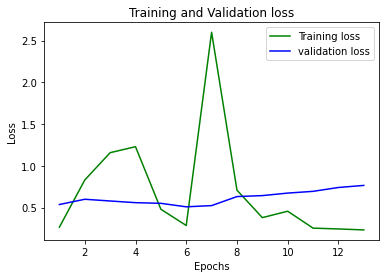

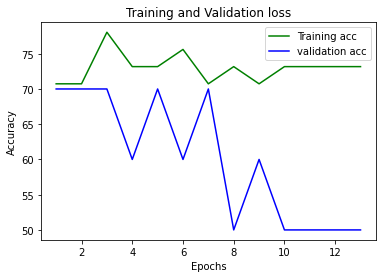

 Training Teacher 38
Epoch: 1 
	Train Loss: 0.383270 	Train Acc: 60.975610 
	Valid Loss: 0.719355 	Valid Acc: 70.000000
Epoch: 2 
	Train Loss: 0.318076 	Train Acc: 63.414634 
	Valid Loss: 0.732741 	Valid Acc: 70.000000
Epoch: 3 
	Train Loss: 0.786375 	Train Acc: 63.414634 
	Valid Loss: 0.728577 	Valid Acc: 70.000000
Epoch: 4 
	Train Loss: 0.801432 	Train Acc: 60.975610 
	Valid Loss: 0.707219 	Valid Acc: 80.000000
Epoch: 5 
	Train Loss: 0.644189 	Train Acc: 58.536585 
	Valid Loss: 0.685633 	Valid Acc: 80.000000
Epoch: 6 
	Train Loss: 0.587922 	Train Acc: 73.170732 
	Valid Loss: 0.690418 	Valid Acc: 70.000000
Epoch: 7 
	Train Loss: 0.357428 	Train Acc: 70.731707 
	Valid Loss: 0.703008 	Valid Acc: 70.000000
Epoch: 8 
	Train Loss: 0.519613 	Train Acc: 68.292683 
	Valid Loss: 0.719156 	Valid Acc: 70.000000
Epoch: 9 
	Train Loss: 0.512093 	Train Acc: 65.853659 
	Valid Loss: 0.691671 	Valid Acc: 70.000000
Epoch: 10 
	Train Loss: 0.357789 	Train Acc: 63.414634 
	Valid Loss: 0.689554 	Valid Acc

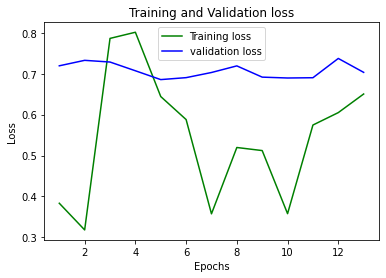

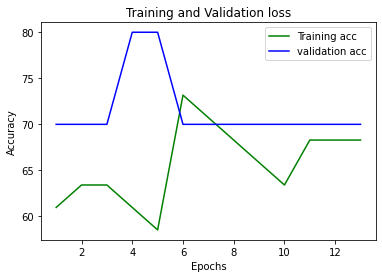

 Training Teacher 39
Epoch: 1 
	Train Loss: 0.384586 	Train Acc: 58.536585 
	Valid Loss: 0.526395 	Valid Acc: 70.000000
Epoch: 2 
	Train Loss: 0.362332 	Train Acc: 58.536585 
	Valid Loss: 0.542180 	Valid Acc: 70.000000
Epoch: 3 
	Train Loss: 0.510767 	Train Acc: 58.536585 
	Valid Loss: 0.545233 	Valid Acc: 70.000000
Epoch: 4 
	Train Loss: 0.646074 	Train Acc: 58.536585 
	Valid Loss: 0.538304 	Valid Acc: 70.000000
Epoch: 5 
	Train Loss: 0.768733 	Train Acc: 56.097561 
	Valid Loss: 0.547652 	Valid Acc: 70.000000
Epoch: 6 
	Train Loss: 0.632778 	Train Acc: 58.536585 
	Valid Loss: 0.545568 	Valid Acc: 60.000000
Epoch: 7 
	Train Loss: 0.616080 	Train Acc: 53.658537 
	Valid Loss: 0.544296 	Valid Acc: 80.000000
Epoch: 8 
	Train Loss: 0.392688 	Train Acc: 60.975610 
	Valid Loss: 0.546879 	Valid Acc: 70.000000
Epoch: 9 
	Train Loss: 0.606740 	Train Acc: 56.097561 
	Valid Loss: 0.547941 	Valid Acc: 70.000000
Epoch: 10 
	Train Loss: 0.350349 	Train Acc: 56.097561 
	Valid Loss: 0.536320 	Valid Acc

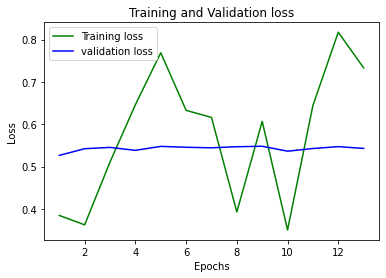

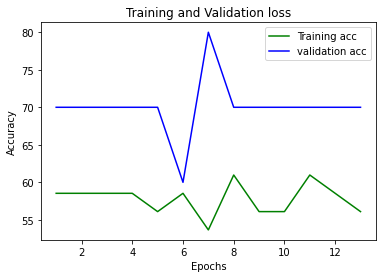

 Training Teacher 40
Epoch: 1 
	Train Loss: 0.848748 	Train Acc: 75.609756 
	Valid Loss: 0.444199 	Valid Acc: 80.000000
Epoch: 2 
	Train Loss: 0.610876 	Train Acc: 73.170732 
	Valid Loss: 0.461690 	Valid Acc: 80.000000
Epoch: 3 
	Train Loss: 0.293806 	Train Acc: 73.170732 
	Valid Loss: 0.468407 	Valid Acc: 80.000000
Epoch: 4 
	Train Loss: 0.377522 	Train Acc: 78.048780 
	Valid Loss: 0.475302 	Valid Acc: 80.000000
Epoch: 5 
	Train Loss: 0.620930 	Train Acc: 73.170732 
	Valid Loss: 0.468987 	Valid Acc: 80.000000
Epoch: 6 
	Train Loss: 0.528598 	Train Acc: 78.048780 
	Valid Loss: 0.459740 	Valid Acc: 80.000000
Epoch: 7 
	Train Loss: 0.579805 	Train Acc: 75.609756 
	Valid Loss: 0.450461 	Valid Acc: 80.000000
Epoch: 8 
	Train Loss: 0.307342 	Train Acc: 80.487805 
	Valid Loss: 0.448203 	Valid Acc: 80.000000
Epoch: 9 
	Train Loss: 0.545424 	Train Acc: 75.609756 
	Valid Loss: 0.431326 	Valid Acc: 80.000000
Epoch: 10 
	Train Loss: 0.251085 	Train Acc: 78.048780 
	Valid Loss: 0.428453 	Valid Acc

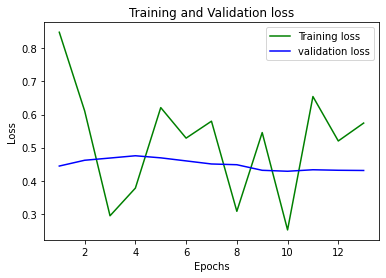

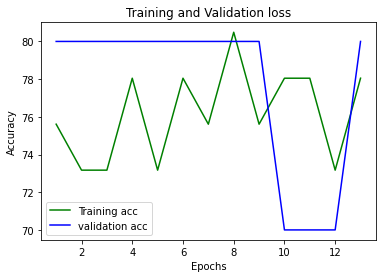

 Training Teacher 41
Epoch: 1 
	Train Loss: 0.431868 	Train Acc: 56.097561 
	Valid Loss: 0.581123 	Valid Acc: 80.000000
Epoch: 2 
	Train Loss: 2.163541 	Train Acc: 56.097561 
	Valid Loss: 0.582759 	Valid Acc: 80.000000
Epoch: 3 
	Train Loss: 0.956693 	Train Acc: 53.658537 
	Valid Loss: 0.582932 	Valid Acc: 70.000000
Epoch: 4 
	Train Loss: 0.671442 	Train Acc: 63.414634 
	Valid Loss: 0.644628 	Valid Acc: 80.000000
Epoch: 5 
	Train Loss: 0.556891 	Train Acc: 60.975610 
	Valid Loss: 0.657848 	Valid Acc: 70.000000
Epoch: 6 
	Train Loss: 0.857293 	Train Acc: 60.975610 
	Valid Loss: 0.664077 	Valid Acc: 70.000000
Epoch: 7 
	Train Loss: 0.385511 	Train Acc: 63.414634 
	Valid Loss: 0.669895 	Valid Acc: 60.000000
Epoch: 8 
	Train Loss: 0.668220 	Train Acc: 68.292683 
	Valid Loss: 0.660044 	Valid Acc: 60.000000
Epoch: 9 
	Train Loss: 0.642602 	Train Acc: 70.731707 
	Valid Loss: 0.656652 	Valid Acc: 60.000000
Epoch: 10 
	Train Loss: 0.623911 	Train Acc: 70.731707 
	Valid Loss: 0.653536 	Valid Acc

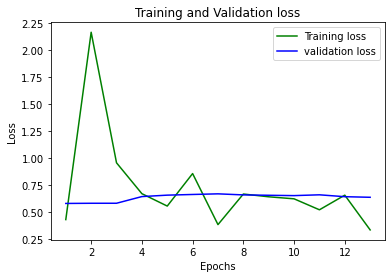

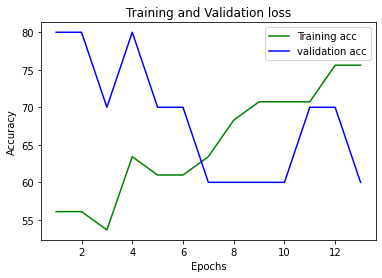

 Training Teacher 42
Epoch: 1 
	Train Loss: 0.633947 	Train Acc: 73.170732 
	Valid Loss: 0.674579 	Valid Acc: 40.000000
Epoch: 2 
	Train Loss: 0.513937 	Train Acc: 68.292683 
	Valid Loss: 0.668198 	Valid Acc: 50.000000
Epoch: 3 
	Train Loss: 0.324937 	Train Acc: 65.853659 
	Valid Loss: 0.661079 	Valid Acc: 50.000000
Epoch: 4 
	Train Loss: 0.710528 	Train Acc: 58.536585 
	Valid Loss: 0.660269 	Valid Acc: 50.000000
Epoch: 5 
	Train Loss: 0.672833 	Train Acc: 65.853659 
	Valid Loss: 0.666791 	Valid Acc: 50.000000
Epoch: 6 
	Train Loss: 0.624773 	Train Acc: 73.170732 
	Valid Loss: 0.662857 	Valid Acc: 80.000000
Epoch: 7 
	Train Loss: 0.424806 	Train Acc: 85.365854 
	Valid Loss: 0.655552 	Valid Acc: 100.000000
Epoch: 8 
	Train Loss: 0.475361 	Train Acc: 80.487805 
	Valid Loss: 0.649704 	Valid Acc: 100.000000
Epoch: 9 
	Train Loss: 0.526000 	Train Acc: 85.365854 
	Valid Loss: 0.639558 	Valid Acc: 100.000000
Epoch: 10 
	Train Loss: 0.886151 	Train Acc: 87.804878 
	Valid Loss: 0.631611 	Valid 

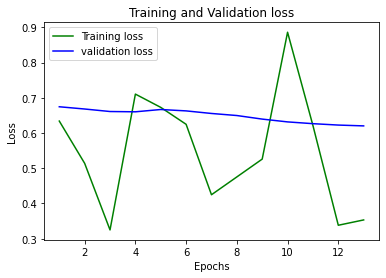

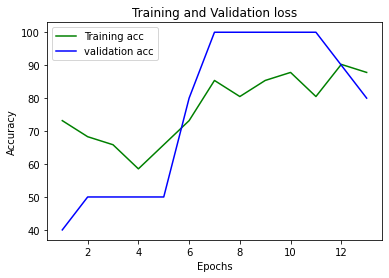

 Training Teacher 43
Epoch: 1 
	Train Loss: 0.711678 	Train Acc: 68.292683 
	Valid Loss: 0.714541 	Valid Acc: 40.000000
Epoch: 2 
	Train Loss: 0.806777 	Train Acc: 63.414634 
	Valid Loss: 0.694250 	Valid Acc: 50.000000
Epoch: 3 
	Train Loss: 0.678195 	Train Acc: 70.731707 
	Valid Loss: 0.662594 	Valid Acc: 50.000000
Epoch: 4 
	Train Loss: 0.514695 	Train Acc: 68.292683 
	Valid Loss: 0.671236 	Valid Acc: 60.000000
Epoch: 5 
	Train Loss: 0.552694 	Train Acc: 65.853659 
	Valid Loss: 0.656079 	Valid Acc: 60.000000
Epoch: 6 
	Train Loss: 0.385736 	Train Acc: 75.609756 
	Valid Loss: 0.651636 	Valid Acc: 50.000000
Epoch: 7 
	Train Loss: 0.481862 	Train Acc: 73.170732 
	Valid Loss: 0.625334 	Valid Acc: 60.000000
Epoch: 8 
	Train Loss: 0.486802 	Train Acc: 73.170732 
	Valid Loss: 0.642544 	Valid Acc: 60.000000
Epoch: 9 
	Train Loss: 0.418388 	Train Acc: 78.048780 
	Valid Loss: 0.662018 	Valid Acc: 60.000000
Epoch: 10 
	Train Loss: 0.921099 	Train Acc: 75.609756 
	Valid Loss: 0.665262 	Valid Acc

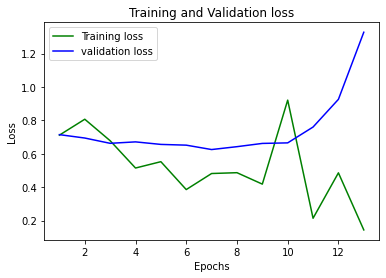

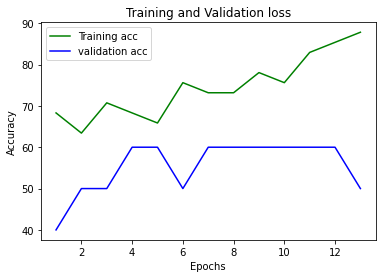

 Training Teacher 44
Epoch: 1 
	Train Loss: 0.425786 	Train Acc: 78.048780 
	Valid Loss: 0.686836 	Valid Acc: 60.000000
Epoch: 2 
	Train Loss: 0.304331 	Train Acc: 78.048780 
	Valid Loss: 0.758152 	Valid Acc: 60.000000
Epoch: 3 
	Train Loss: 0.232784 	Train Acc: 78.048780 
	Valid Loss: 0.665475 	Valid Acc: 70.000000
Epoch: 4 
	Train Loss: 0.284865 	Train Acc: 80.487805 
	Valid Loss: 0.708523 	Valid Acc: 60.000000
Epoch: 5 
	Train Loss: 0.219288 	Train Acc: 73.170732 
	Valid Loss: 0.686548 	Valid Acc: 60.000000
Epoch: 6 
	Train Loss: 0.175745 	Train Acc: 80.487805 
	Valid Loss: 0.700763 	Valid Acc: 60.000000
Epoch: 7 
	Train Loss: 0.166618 	Train Acc: 82.926829 
	Valid Loss: 0.845416 	Valid Acc: 60.000000
Epoch: 8 
	Train Loss: 0.135293 	Train Acc: 87.804878 
	Valid Loss: 0.724008 	Valid Acc: 60.000000
Epoch: 9 
	Train Loss: 0.311144 	Train Acc: 87.804878 
	Valid Loss: 0.856918 	Valid Acc: 40.000000
Epoch: 10 
	Train Loss: 0.772977 	Train Acc: 85.365854 
	Valid Loss: 0.862890 	Valid Acc

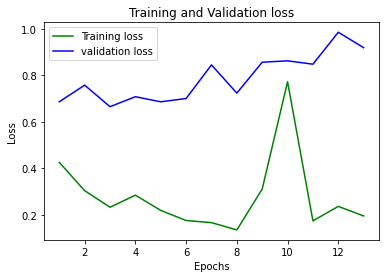

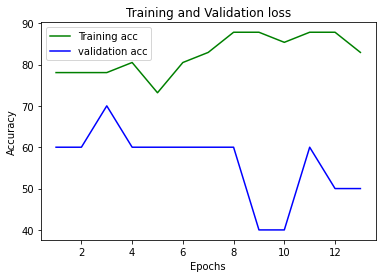

 Training Teacher 45
Epoch: 1 
	Train Loss: 1.196605 	Train Acc: 68.292683 
	Valid Loss: 3.631911 	Valid Acc: 60.000000
Epoch: 2 
	Train Loss: 0.281341 	Train Acc: 70.731707 
	Valid Loss: 4.058882 	Valid Acc: 40.000000
Epoch: 3 
	Train Loss: 0.284415 	Train Acc: 75.609756 
	Valid Loss: 4.270701 	Valid Acc: 40.000000
Epoch: 4 
	Train Loss: 0.323243 	Train Acc: 75.609756 
	Valid Loss: 3.271179 	Valid Acc: 40.000000
Epoch: 5 
	Train Loss: 0.581393 	Train Acc: 80.487805 
	Valid Loss: 3.201177 	Valid Acc: 50.000000
Epoch: 6 
	Train Loss: 0.328365 	Train Acc: 75.609756 
	Valid Loss: 3.305234 	Valid Acc: 50.000000
Epoch: 7 
	Train Loss: 0.244444 	Train Acc: 75.609756 
	Valid Loss: 3.936724 	Valid Acc: 50.000000
Epoch: 8 
	Train Loss: 0.610390 	Train Acc: 80.487805 
	Valid Loss: 3.465895 	Valid Acc: 50.000000
Epoch: 9 
	Train Loss: 0.224989 	Train Acc: 78.048780 
	Valid Loss: 4.499994 	Valid Acc: 40.000000
Epoch: 10 
	Train Loss: 0.498366 	Train Acc: 78.048780 
	Valid Loss: 4.057079 	Valid Acc

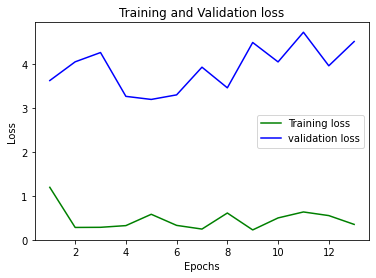

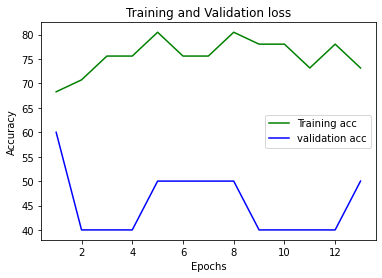

 Training Teacher 46
Epoch: 1 
	Train Loss: 0.192805 	Train Acc: 80.487805 
	Valid Loss: 0.190280 	Valid Acc: 90.000000
Epoch: 2 
	Train Loss: 0.824856 	Train Acc: 80.487805 
	Valid Loss: 0.182364 	Valid Acc: 90.000000
Epoch: 3 
	Train Loss: 0.191345 	Train Acc: 80.487805 
	Valid Loss: 0.201024 	Valid Acc: 90.000000
Epoch: 4 
	Train Loss: 0.180649 	Train Acc: 85.365854 
	Valid Loss: 0.204098 	Valid Acc: 90.000000
Epoch: 5 
	Train Loss: 0.171528 	Train Acc: 85.365854 
	Valid Loss: 0.180016 	Valid Acc: 90.000000
Epoch: 6 
	Train Loss: 0.135622 	Train Acc: 87.804878 
	Valid Loss: 0.216030 	Valid Acc: 90.000000
Epoch: 7 
	Train Loss: 0.158874 	Train Acc: 87.804878 
	Valid Loss: 0.210262 	Valid Acc: 90.000000
Epoch: 8 
	Train Loss: 0.408724 	Train Acc: 85.365854 
	Valid Loss: 0.196917 	Valid Acc: 90.000000
Epoch: 9 
	Train Loss: 0.151276 	Train Acc: 87.804878 
	Valid Loss: 0.177670 	Valid Acc: 90.000000
Epoch: 10 
	Train Loss: 0.120020 	Train Acc: 90.243902 
	Valid Loss: 0.179449 	Valid Acc

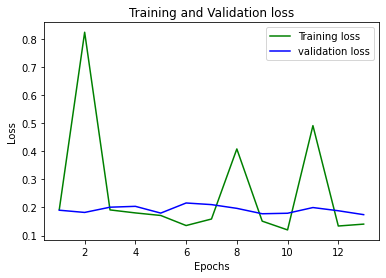

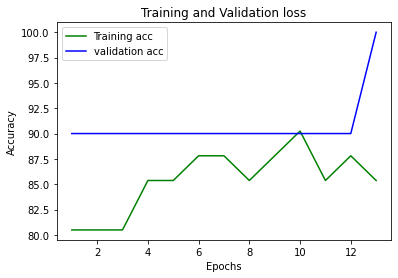

 Training Teacher 47
Epoch: 1 
	Train Loss: 0.501452 	Train Acc: 80.487805 
	Valid Loss: 0.476458 	Valid Acc: 90.000000
Epoch: 2 
	Train Loss: 0.483588 	Train Acc: 85.365854 
	Valid Loss: 0.501591 	Valid Acc: 90.000000
Epoch: 3 
	Train Loss: 0.305779 	Train Acc: 78.048780 
	Valid Loss: 0.502617 	Valid Acc: 80.000000
Epoch: 4 
	Train Loss: 0.343529 	Train Acc: 75.609756 
	Valid Loss: 0.430845 	Valid Acc: 70.000000
Epoch: 5 
	Train Loss: 1.327182 	Train Acc: 73.170732 
	Valid Loss: 0.441386 	Valid Acc: 60.000000
Epoch: 6 
	Train Loss: 0.294892 	Train Acc: 70.731707 
	Valid Loss: 0.417609 	Valid Acc: 60.000000
Epoch: 7 
	Train Loss: 0.906820 	Train Acc: 73.170732 
	Valid Loss: 0.411401 	Valid Acc: 60.000000
Epoch: 8 
	Train Loss: 0.514165 	Train Acc: 73.170732 
	Valid Loss: 0.441711 	Valid Acc: 70.000000
Epoch: 9 
	Train Loss: 0.451976 	Train Acc: 73.170732 
	Valid Loss: 0.416991 	Valid Acc: 70.000000
Epoch: 10 
	Train Loss: 0.398697 	Train Acc: 73.170732 
	Valid Loss: 0.456735 	Valid Acc

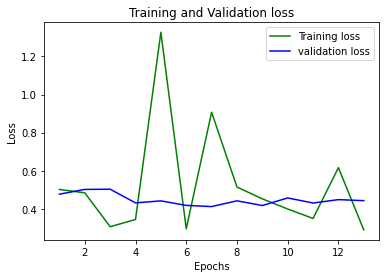

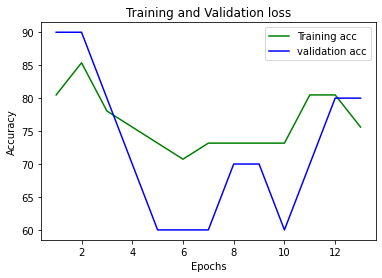

 Training Teacher 48
Epoch: 1 
	Train Loss: 0.757727 	Train Acc: 73.170732 
	Valid Loss: 0.416443 	Valid Acc: 80.000000
Epoch: 2 
	Train Loss: 0.734210 	Train Acc: 73.170732 
	Valid Loss: 0.412017 	Valid Acc: 80.000000
Epoch: 3 
	Train Loss: 0.809955 	Train Acc: 70.731707 
	Valid Loss: 0.370485 	Valid Acc: 80.000000
Epoch: 4 
	Train Loss: 0.996795 	Train Acc: 73.170732 
	Valid Loss: 0.366679 	Valid Acc: 80.000000
Epoch: 5 
	Train Loss: 0.717772 	Train Acc: 75.609756 
	Valid Loss: 0.347007 	Valid Acc: 80.000000
Epoch: 6 
	Train Loss: 0.708219 	Train Acc: 68.292683 
	Valid Loss: 0.375234 	Valid Acc: 80.000000
Epoch: 7 
	Train Loss: 0.294948 	Train Acc: 75.609756 
	Valid Loss: 0.382493 	Valid Acc: 80.000000
Epoch: 8 
	Train Loss: 0.720613 	Train Acc: 68.292683 
	Valid Loss: 0.380508 	Valid Acc: 80.000000
Epoch: 9 
	Train Loss: 0.304661 	Train Acc: 70.731707 
	Valid Loss: 0.348433 	Valid Acc: 80.000000
Epoch: 10 
	Train Loss: 0.441825 	Train Acc: 75.609756 
	Valid Loss: 0.381442 	Valid Acc

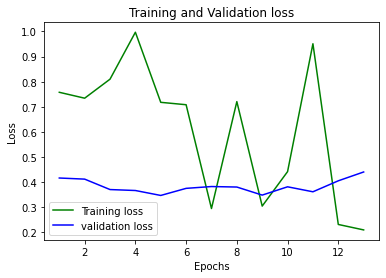

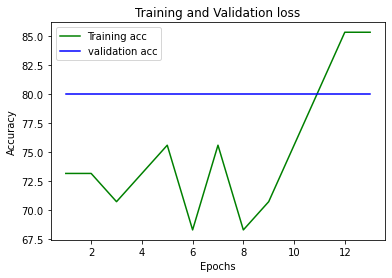

 Training Teacher 49
Epoch: 1 
	Train Loss: 0.430685 	Train Acc: 73.170732 
	Valid Loss: 0.486439 	Valid Acc: 80.000000
Epoch: 2 
	Train Loss: 0.333769 	Train Acc: 75.609756 
	Valid Loss: 0.409088 	Valid Acc: 80.000000
Epoch: 3 
	Train Loss: 0.256922 	Train Acc: 82.926829 
	Valid Loss: 0.372677 	Valid Acc: 90.000000
Epoch: 4 
	Train Loss: 0.863477 	Train Acc: 82.926829 
	Valid Loss: 0.396480 	Valid Acc: 90.000000
Epoch: 5 
	Train Loss: 0.464338 	Train Acc: 82.926829 
	Valid Loss: 0.433311 	Valid Acc: 90.000000
Epoch: 6 
	Train Loss: 0.200545 	Train Acc: 82.926829 
	Valid Loss: 0.527745 	Valid Acc: 80.000000
Epoch: 7 
	Train Loss: 0.345722 	Train Acc: 82.926829 
	Valid Loss: 0.646495 	Valid Acc: 70.000000
Epoch: 8 
	Train Loss: 0.317661 	Train Acc: 75.609756 
	Valid Loss: 0.664820 	Valid Acc: 70.000000
Epoch: 9 
	Train Loss: 0.332207 	Train Acc: 78.048780 
	Valid Loss: 0.405671 	Valid Acc: 90.000000
Epoch: 10 
	Train Loss: 0.201478 	Train Acc: 92.682927 
	Valid Loss: 0.403026 	Valid Acc

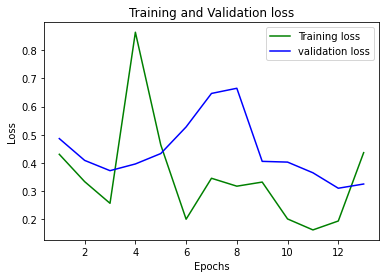

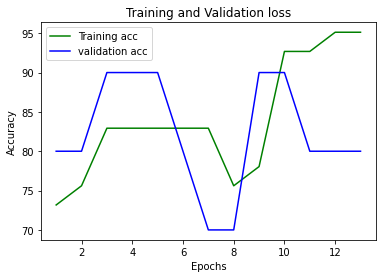

 Training Teacher 50
Epoch: 1 
	Train Loss: 0.236782 	Train Acc: 85.365854 
	Valid Loss: 0.196459 	Valid Acc: 100.000000
Epoch: 2 
	Train Loss: 0.254988 	Train Acc: 85.365854 
	Valid Loss: 0.219467 	Valid Acc: 100.000000
Epoch: 3 
	Train Loss: 0.244653 	Train Acc: 85.365854 
	Valid Loss: 0.217388 	Valid Acc: 100.000000
Epoch: 4 
	Train Loss: 0.446154 	Train Acc: 85.365854 
	Valid Loss: 0.219655 	Valid Acc: 100.000000
Epoch: 5 
	Train Loss: 0.315420 	Train Acc: 85.365854 
	Valid Loss: 0.214192 	Valid Acc: 100.000000
Epoch: 6 
	Train Loss: 0.237083 	Train Acc: 85.365854 
	Valid Loss: 0.229641 	Valid Acc: 100.000000
Epoch: 7 
	Train Loss: 0.231486 	Train Acc: 85.365854 
	Valid Loss: 0.241617 	Valid Acc: 90.000000
Epoch: 8 
	Train Loss: 0.305315 	Train Acc: 85.365854 
	Valid Loss: 0.243270 	Valid Acc: 90.000000
Epoch: 9 
	Train Loss: 0.238128 	Train Acc: 85.365854 
	Valid Loss: 0.220205 	Valid Acc: 90.000000
Epoch: 10 
	Train Loss: 0.194528 	Train Acc: 82.926829 
	Valid Loss: 0.241979 	Val

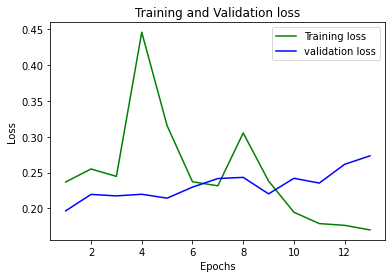

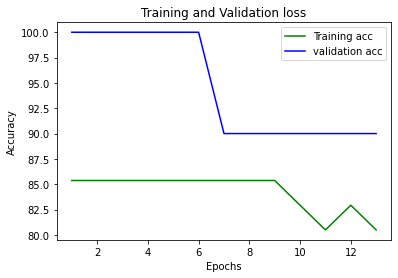

In [12]:
#Training teachers
# Training teachers
teacher_models = []
i = 1
for trainloader, validloader in zip(trainloaders, validloaders):
  print(" Training Teacher {}".format(i))
  teacher_model = train(epochs, trainloader, validloader, model, optimizer, criterion, True)
  teacher_models.append(teacher_model)
  i+=1
  print("="*40)

In [13]:
#Get private labels for training student
# get private labels
def student_train_labels(teacher_models, dataloader):
  student_labels = []

  # get label from each teacher
  for model in teacher_models:
    student_label = []
    for images,_ in dataloader:
      with torch.no_grad():
        images = images.cuda()
        outputs = model(images)
        preds = torch.argmax(torch.exp(outputs), dim=1)
      student_label.append(preds.tolist())

    # add all teacher predictions to student_labels  
    student_label = sum(student_label, [])
    student_labels.append(student_label)
  return student_labels

predicted_labels = student_train_labels(teacher_models, student_train_loader)     
predicted_labels = np.array([np.array(p) for p in predicted_labels]).transpose(1, 0)

# We see here that we have 5 labels for each image in our dataset
print(predicted_labels.shape)
# See labels of 3rd Image Scan
print(predicted_labels[3])

(468, 50)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [30]:
#Get private labels with the most votes count and add noise them
def add_noise(predicted_labels, epsilon=0.001):
  noisy_labels = []
  for preds in predicted_labels:

    # get labels with max votes
    label_counts = np.bincount(preds, minlength=2)

    # add laplacian noise to label
    epsilon = epsilon
    beta = 1/epsilon
    for i in range(len(label_counts)):
      label_counts[i] += np.random.laplace(0, beta, 1)

    # after adding noise we get labels with max counts
    new_label = np.argmax(label_counts)
    noisy_labels.append(new_label)

  #return noisy_labels
  return np.array(noisy_labels)

labels_with_noise = add_noise(predicted_labels, epsilon=0.01)  
print(labels_with_noise)
print(labels_with_noise.shape)

[0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 1
 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0
 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1 1
 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1
 0 0 0 1 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1
 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0
 1 0 1 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1
 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0
 1 0 0 1 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 1 1 0
 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 0 1 1 0 1 1 1 1 1
 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 0
 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1]
(468,)


In [31]:
import csv
def write_csv(data):
    with open('labels.csv', 'w') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(data)

write_csv(labels_with_noise)

In [32]:
# Performing PATE analysis
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=predicted_labels.T, indices=labels_with_noise, noise_eps=0.01, delta=1e-5)
print('Data dependent epsilon:', data_dep_eps)
print('Data independent epsilon:', data_ind_eps)

l of 7.0 too large to compute sensitivity with noise epsilon 0.3
l of 7.0 too large to compute sensitivity with noise epsilon 0.3
l of 8.0 too large to compute sensitivity with noise epsilon 0.3
l of 8.0 too large to compute sensitivity with noise epsilon 0.3
l of 7.0 too large to compute sensitivity with noise epsilon 0.3
l of 7.0 too large to compute sensitivity with noise epsilon 0.3
l of 8.0 too large to compute sensitivity with noise epsilon 0.3
l of 8.0 too large to compute sensitivity with noise epsilon 0.3
l of 7.0 too large to compute sensitivity with noise epsilon 0.3
l of 7.0 too large to compute sensitivity with noise epsilon 0.3
l of 8.0 too large to compute sensitivity with noise epsilon 0.3
l of 8.0 too large to compute sensitivity with noise epsilon 0.3
l of 7.0 too large to compute sensitivity with noise epsilon 0.3
l of 7.0 too large to compute sensitivity with noise epsilon 0.3
l of 8.0 too large to compute sensitivity with noise epsilon 0.3
l of 8.0 too large to com

In [33]:
# We have to create a new training dataloader for the student with the newly created
# labels with noise. We have to replace the old labels with the new labels
def new_student_data_loader(dataloader, noisy_labels, batch_size=20):
  image_list = []
  for image,_ in dataloader:
    image_list.append(image)

  data = np.vstack(image_list)
  new_dataset = list(zip(data, noisy_labels))
  new_dataloader = DataLoader(new_dataset, batch_size, shuffle=False)

  return new_dataloader

labeled_student_trainloader = new_student_data_loader(student_train_loader, labels_with_noise)
len(labeled_student_trainloader),len(student_valid_loader)

(24, 6)

Epoch: 1 
	Train Loss: 0.267736 	Train Acc: 88.247863 
	Valid Loss: 0.624492 	Valid Acc: 78.448276
	Validation loss decreased (inf --> 0.624492).  Saving model ...
Epoch: 2 
	Train Loss: 0.114902 	Train Acc: 95.512821 
	Valid Loss: 0.745977 	Valid Acc: 81.896552
Epoch: 3 
	Train Loss: 0.074343 	Train Acc: 97.863248 
	Valid Loss: 0.774465 	Valid Acc: 81.896552
Epoch: 4 
	Train Loss: 0.068139 	Train Acc: 97.649573 
	Valid Loss: 0.856568 	Valid Acc: 81.034483
Epoch: 5 
	Train Loss: 0.058838 	Train Acc: 98.290598 
	Valid Loss: 0.950018 	Valid Acc: 79.310345
Epoch: 6 
	Train Loss: 0.060015 	Train Acc: 97.863248 
	Valid Loss: 1.097608 	Valid Acc: 80.172414
Epoch: 7 
	Train Loss: 0.051304 	Train Acc: 98.504274 
	Valid Loss: 1.150451 	Valid Acc: 81.896552
Epoch: 8 
	Train Loss: 0.042670 	Train Acc: 98.717949 
	Valid Loss: 1.264423 	Valid Acc: 81.034483
Epoch: 9 
	Train Loss: 0.028564 	Train Acc: 99.358974 
	Valid Loss: 1.316795 	Valid Acc: 81.896552
Epoch: 10 
	Train Loss: 0.019059 	Train Acc:

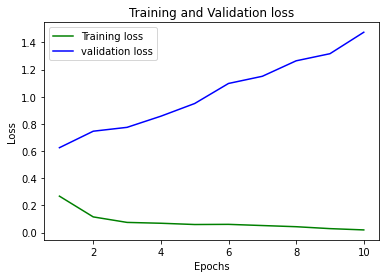

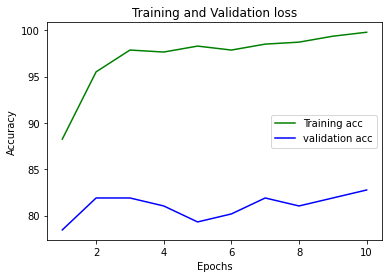

In [34]:
epochs = 10
student_model = train(epochs, labeled_student_trainloader, student_valid_loader, model, optimizer, criterion, True, save_path='./models/student.pth.tar', is_not_teacher=True)

Epoch: 1 
	Train Loss: 0.574856 	Train Acc: 82.478632 
	Valid Loss: 0.459839 	Valid Acc: 76.724138
	Validation loss decreased (inf --> 0.459839).  Saving model ...
Epoch: 2 
	Train Loss: 0.242835 	Train Acc: 90.811966 
	Valid Loss: 0.401522 	Valid Acc: 80.172414
	Validation loss decreased (0.459839 --> 0.401522).  Saving model ...
Epoch: 3 
	Train Loss: 0.171139 	Train Acc: 92.521368 
	Valid Loss: 0.424536 	Valid Acc: 81.034483
Epoch: 4 
	Train Loss: 0.150387 	Train Acc: 93.803419 
	Valid Loss: 0.412290 	Valid Acc: 81.896552
Epoch: 5 
	Train Loss: 0.116567 	Train Acc: 96.794872 
	Valid Loss: 0.426328 	Valid Acc: 81.034483
Epoch: 6 
	Train Loss: 0.105673 	Train Acc: 96.581197 
	Valid Loss: 0.422707 	Valid Acc: 82.758621
Epoch: 7 
	Train Loss: 0.095614 	Train Acc: 96.367521 
	Valid Loss: 0.473328 	Valid Acc: 82.758621
Epoch: 8 
	Train Loss: 0.089365 	Train Acc: 96.794872 
	Valid Loss: 0.497466 	Valid Acc: 79.310345
Epoch: 9 
	Train Loss: 0.081728 	Train Acc: 97.649573 
	Valid Loss: 0.478

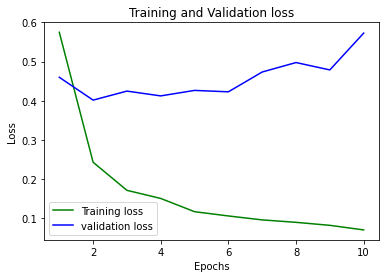

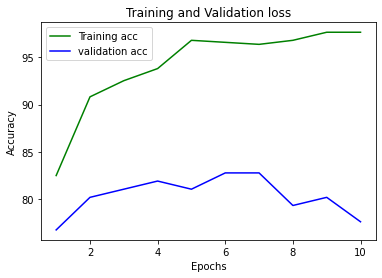

In [35]:
# Normal DL Training
epochs = 10
normal_model = train(epochs, student_train_loader, student_valid_loader, model, optimizer, criterion, True, save_path='./models/normal.pth.tar', is_not_teacher=True)


In [36]:
# Create a dataloader for the test Dataset
batch_size=16
print(len(validset))
dataloader = DataLoader(validset, batch_size=batchsize, shuffle=False)

146


In [37]:
# We set a seed for the dataset to prevent it from producing different values every time it is run
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def test(dataloader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    Y_true = []
    Y_pred = []
    
    model.eval()
    for batch_idx, (data, target) in enumerate(dataloader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # calculate the loss
        loss = criterion(output, target)

        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        temp_pred = pred 
        
        Y_pred+=(temp_pred.cpu().numpy().transpose().tolist())
        # print(temp_pred.cpu().numpy().transpose())
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('\tTest Loss: {:.6f}'.format(test_loss))
    print('\tTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    Y_pred = sum(Y_pred,[])
    
    Y_true = [int(dataloader.dataset.img_list[i][1]) for i in range(len(dataloader.dataset.img_list)) ]
    
    print(confusion_matrix(Y_true,Y_pred))

# call test function
print("Student Model")     
test(dataloader, student_model, criterion, True)


print("\n=======================\nNormal Model")
test(dataloader, normal_model, criterion, True)


Student Model
	Test Loss: 0.660407
	Test Accuracy: 70% (103/146)
[[64 16]
 [27 39]]

Normal Model
	Test Loss: 0.683462
	Test Accuracy: 71% (104/146)
[[64 16]
 [26 40]]
